In [32]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import pickle
from glob import glob
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [33]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")
    

GPU is available


In [4]:
train_path = "../train/train"
# The glob module finds all the pathnames matching a specified pattern
train_pkl_lst = glob(os.path.join(train_path, '*'))
with open(train_pkl_lst[1], 'rb') as f:
    training_sample = pickle.load(f)

# LSTM

In [34]:
class MyLSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(MyLSTM, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        #Initializing hidden state for first input using method defined below
        h_t, c_t = self.init_hidden(batch_size)

        #print(x.size())
        #print(x.size(-1))
        # Passing in the input and hidden state into the model and obtaining outputs
        out, (h_t, c_t) = self.lstm(x, (h_t, c_t))
        
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out, h_t
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        h_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        c_0 =  torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)       
         # We'll send the tensor holding the hidden state to the device we specified earlier as well
        return h_0, c_0

In [6]:
# Autogressive vs. direct mapping
# Batch Norm? 

# Dataset

In [35]:
class ArgoverseDataset(torch.utils.data.Dataset):
    """Dataset class for Argoverse"""
    
    def __init__(self, 
                 data_path,
                 sample_indices):
        super(ArgoverseDataset, self).__init__()
        
        self.data_path = data_path
        self.sample_indices = sample_indices
        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.sample_indices)

    def __getitem__(self, idx):
        
        # Load one scene
        pkl_path = self.pkl_list[self.sample_indices[idx]]
        with open(pkl_path, 'rb') as f:
            scene = pickle.load(f)
            
        # the index of agent to be predicted 
        pred_id = np.where(scene["track_id"] == scene['agent_id'])[0][0]
        
        # input: p_in & v_in; output: p_out
        inp_scene = np.dstack([scene['p_in'], scene['v_in']])
        out_scene = np.dstack([scene['p_out'], scene['v_out']])
        
        # Normalization 
        min_vecs = np.min(inp_scene, axis = (0,1))
        max_vecs = np.max(inp_scene, axis = (0,1))
        
        # Normalize by vectors
        inp = (inp_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        out = (out_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        
        dat = np.concatenate((inp, out), axis=0)
        
        train_data = []
        window_size = 20
        interval = 7
        for i in range(0, len(dat), interval):
            #print(len(dat[i:i+input_length]))
            if i + window_size < len(dat): 
                train_data.append(dat[i:i+window_size])
            
        #print(len(train_data))
        #print(train_data)
        
        input_seq = []
        target_seq = []
        for i in range(len(train_data)):
            input_seq.append(train_data[i][:-1])
            target_seq.append(train_data[i][1:])
        
        #print(input_seq)
        
        input_seq = np.array(input_seq, dtype=np.float32)
        target_seq = np.array(target_seq, dtype=np.float32)
        
        #print(input_seq.shape)
        #print(target_seq.shape)
        
        # Convert to float torch tensor
        #return torch.from_numpy(inp).float(), torch.from_numpy(out).float() #torch.from_numpy(out[:,:2]).float()
        return torch.from_numpy(input_seq).float(), torch.from_numpy(target_seq).float()

In [36]:
training_sample['p_out'].shape

(60, 30, 2)

In [37]:
training_sample['v_out'].shape

(60, 30, 2)

In [5]:
# Try different ways of normalization
# Leverage other features. 

# Hyperparameter

In [6]:
# Grid/Random Search

In [38]:
# batch_size = 64
interval = 7 # sampling interval for LSTM
window_size = 20 # number of timesteps to take as input
batch_size = 512
#in_dim = 19*4 # MLP
#out_dim = 4 #30*2 # MLP
input_size = 4 # LSTM
output_size = 4 # LSTM (has to match input_size)
hidden_dim = 256 #128 #32 #128
num_layers = 1 #3
learning_rate = 0.01
decay_rate = 0.95
num_epoch = 1000

# Data Loader

In [39]:
train_path = "../train/train"

# total number of scenes
indices = np.arange(0, 205942)

# train-valid split
np.random.shuffle(indices)
train_indices = indices[:180000]
valid_indices = indices[180000:]

# define datasets
train_set = ArgoverseDataset(train_path, train_indices)
valid_set = ArgoverseDataset(train_path, valid_indices)

# create dataloaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=0)

In [40]:
len(train_set)

180000

In [80]:
# train_set[0]

In [41]:
len(train_loader)

352

# Model, Loss Function and Optimizer

In [42]:
# # RNN, LSTM, 1dCNN, Transformer
# model = MLPNet(in_dim = in_dim, 
#                out_dim = out_dim,
#                hidden_dim = hidden_dim, 
#                num_layers = num_layers).to(device) # move model to gpu 

model = MyLSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=num_layers).to(device)

# Adaptive Moment Estimation computes adaptive learning rates for each parameter. 
# Compute the decaying averages of past and past squared gradients. 

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=decay_rate)  # stepwise learning rate decay
loss_fun = nn.MSELoss()

In [9]:
model.load_state_dict(torch.load('baseline.pt'))

<All keys matched successfully>

In [118]:
# train_path = "./train/train/"
# train_pkl_list = glob(os.path.join(train_path, '*'))
# train_pkl_list.sort()

# train_preds = []
# for idx in range(3):
#     with open(train_pkl_list[idx], 'rb') as f:
#         train_sample = pickle.load(f)
#         pred_id = np.where(train_sample["track_id"] == train_sample['agent_id'])[0][0]
#         inp_scene = np.dstack([train_sample['p_in'], train_sample['v_in']])

#         # Normalization 
#         min_vecs = np.min(inp_scene, axis = (0,1))
#         max_vecs = np.max(inp_scene, axis = (0,1))
        
#         inp = (inp_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        
#         inp = torch.from_numpy(inp).float().to(device).unsqueeze(0)

#         preds = model(inp).cpu().data.numpy()
        
#         # De-Normalization ! 
#         preds = preds * (max_vecs[:2] - min_vecs[:2]) +  min_vecs[:2]
#         train_preds.append(preds)

# Training

In [171]:
for inp, tgt in train_loader:
    print(inp.shape)
    print(tgt.shape)
    print(inp.view(-1, window_size-1, 4).size()) 
    print(inp[0, 0, :, :])
    break
        

torch.Size([512, 5, 19, 4])
torch.Size([512, 5, 19, 4])
torch.Size([2560, 19, 4])
tensor([[1.0000, 1.0000, 0.0566, 0.0473],
        [0.9998, 0.9996, 0.0643, 0.0610],
        [0.9995, 0.9992, 0.0543, 0.0229],
        [0.9993, 0.9988, 0.1135, 0.1166],
        [0.9991, 0.9984, 0.0722, 0.0608],
        [0.9989, 0.9981, 0.1136, 0.1087],
        [0.9987, 0.9977, 0.0845, 0.0779],
        [0.9984, 0.9973, 0.0762, 0.0627],
        [0.9982, 0.9969, 0.0633, 0.0508],
        [0.9980, 0.9965, 0.0501, 0.0407],
        [0.9978, 0.9962, 0.1454, 0.1404],
        [0.9975, 0.9957, 0.0430, 0.0333],
        [0.9973, 0.9954, 0.1270, 0.1274],
        [0.9971, 0.9950, 0.0749, 0.0670],
        [0.9969, 0.9946, 0.0619, 0.0524],
        [0.9966, 0.9942, 0.0747, 0.0485],
        [0.9964, 0.9938, 0.0602, 0.0563],
        [0.9962, 0.9935, 0.1179, 0.1185],
        [0.9959, 0.9930, 0.0306, 0.0269]])


In [43]:
def train_epoch(train_loader, model, optimizer, loss_function):

    train_mse = []
    for inp, tgt in tqdm(train_loader):
        
        inp = inp.view(-1, window_size-1, 4)
        tgt = tgt.view(-1, window_size-1, 4)
        
        #print(inp.size())
        
        inp = inp.to(device)
        tgt = tgt.to(device)
        
        output, hidden = model(inp)
        output = output.to(device)
        #print(output.shape)
        #print(hidden.shape)
        #print(tgt.view(-1, 4).size())
        
        loss = loss_function(output, tgt.view(-1, 4))
        train_mse.append(loss.item()) 
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_mse = round(np.sqrt(np.mean(train_mse)),5)
    
    return train_mse

def eval_epoch(valid_loader, model, loss_function):
    
    valid_mse = []
    #preds = []
    #trues = []
    
    with torch.no_grad():
        for inp, tgt in valid_loader:
            
            inp = inp.view(-1, window_size-1, 4)
            tgt = tgt.view(-1, window_size-1, 4)
            
            inp = inp.to(device)
            tgt = tgt.to(device)
            
            loss = 0
            output, hidden = model(inp)
            output = output.to(device)
                    
            loss = loss_function(output, tgt.view(-1, 4))
            
            #preds.append(pred.cpu().data.numpy())
            #trues.append(tgt.cpu().data.numpy())
            
            valid_mse.append(loss.item())
            
        #preds = np.concatenate(preds, axis = 0)  
        #trues = np.concatenate(trues, axis = 0)  
        valid_mse = round(np.sqrt(np.mean(valid_mse)), 5)
    return valid_mse#, preds, trues


In [14]:
# Learning Rate Decay
# Dropout
# L1/L2 Regulization

In [44]:
len(train_pkl_lst)

205942

 44%|████▍     | 155/352 [01:54<02:39,  1.24it/s]


 88%|████████▊ | 309/352 [04:26<00:47,  1.10s/it]


100%|██████████| 352/352 [05:18<00:00,  1.10it/s]


[0.21745]
0.11777
Epoch 1 | T: 6.30 | Train RMSE: 0.21745 | Valid RMSE: 0.11777


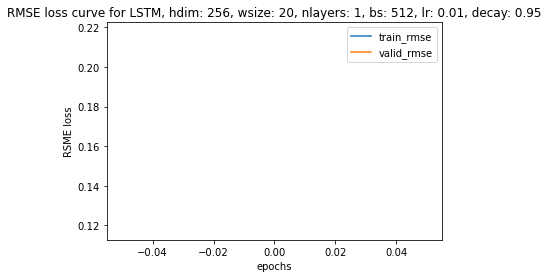

 44%|████▍     | 154/352 [02:13<02:44,  1.20it/s]


 88%|████████▊ | 308/352 [04:36<00:38,  1.13it/s]


100%|██████████| 352/352 [05:26<00:00,  1.08it/s]


[0.21745, 0.11508]
0.11393
Epoch 2 | T: 6.33 | Train RMSE: 0.11508 | Valid RMSE: 0.11393


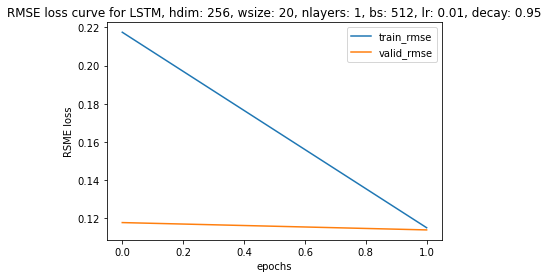

 44%|████▍     | 154/352 [02:12<02:40,  1.24it/s]


 88%|████████▊ | 308/352 [04:27<00:32,  1.36it/s]


100%|██████████| 352/352 [05:11<00:00,  1.13it/s]


[0.21745, 0.11508, 0.11112]
0.11289
Epoch 3 | T: 5.87 | Train RMSE: 0.11112 | Valid RMSE: 0.11289


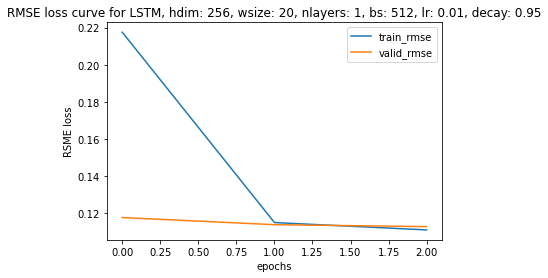

 44%|████▍     | 154/352 [02:01<02:22,  1.39it/s]


 88%|████████▊ | 308/352 [04:01<00:27,  1.58it/s]


100%|██████████| 352/352 [04:31<00:00,  1.30it/s]


[0.21745, 0.11508, 0.11112, 0.11035]
0.11175
Epoch 4 | T: 5.33 | Train RMSE: 0.11035 | Valid RMSE: 0.11175


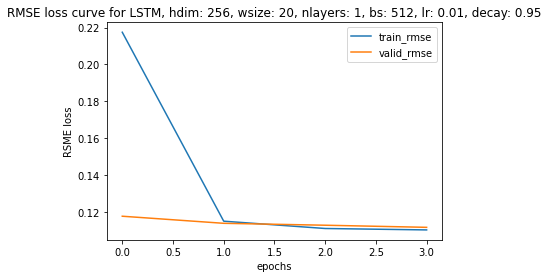

 44%|████▍     | 154/352 [01:57<02:13,  1.48it/s]


 88%|████████▊ | 308/352 [03:49<00:27,  1.63it/s]


100%|██████████| 352/352 [04:14<00:00,  1.38it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982]
0.11143
Epoch 5 | T: 5.10 | Train RMSE: 0.10982 | Valid RMSE: 0.11143


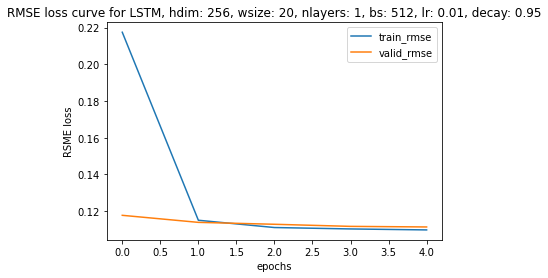

 44%|████▍     | 154/352 [01:50<01:52,  1.76it/s]


 88%|████████▊ | 308/352 [03:43<00:24,  1.78it/s]


100%|██████████| 352/352 [04:08<00:00,  1.41it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919]
0.11111
Epoch 6 | T: 5.03 | Train RMSE: 0.10919 | Valid RMSE: 0.11111


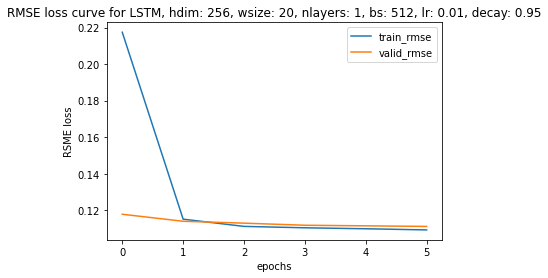

 44%|████▍     | 154/352 [01:48<01:47,  1.84it/s]


 88%|████████▊ | 308/352 [03:44<00:25,  1.70it/s]


100%|██████████| 352/352 [04:09<00:00,  1.41it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872]
0.11048
Epoch 7 | T: 4.84 | Train RMSE: 0.10872 | Valid RMSE: 0.11048


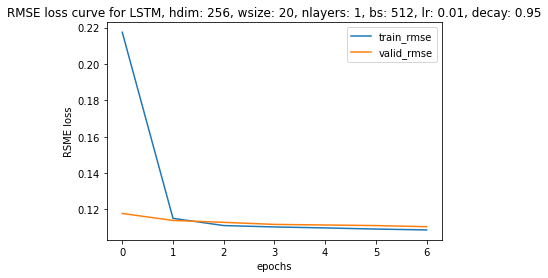

 44%|████▍     | 154/352 [01:46<01:44,  1.90it/s]


 88%|████████▊ | 308/352 [03:41<01:50,  2.50s/it]


100%|██████████| 352/352 [04:04<00:00,  1.44it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829]
0.11035
Epoch 8 | T: 4.76 | Train RMSE: 0.10829 | Valid RMSE: 0.11035


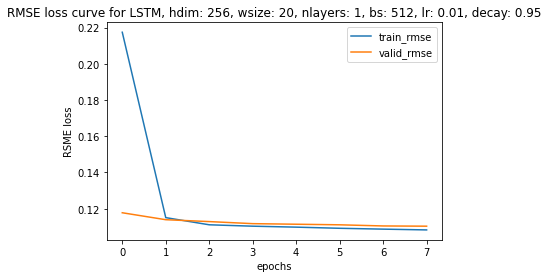

 44%|████▍     | 154/352 [01:50<03:57,  1.20s/it]


 88%|████████▊ | 308/352 [03:24<00:23,  1.88it/s]


100%|██████████| 352/352 [04:09<00:00,  1.41it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804]
0.11019
Epoch 9 | T: 4.56 | Train RMSE: 0.10804 | Valid RMSE: 0.11019


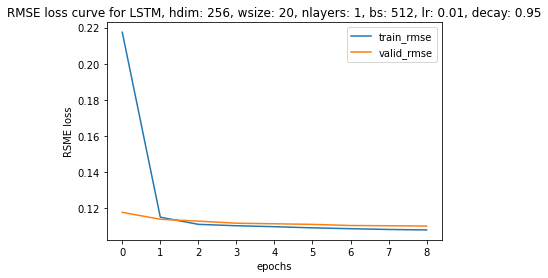

 44%|████▍     | 154/352 [01:44<01:41,  1.96it/s]


 88%|████████▊ | 308/352 [03:41<00:21,  2.06it/s]


100%|██████████| 352/352 [04:18<00:00,  1.36it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777]
0.10982
Epoch 10 | T: 4.72 | Train RMSE: 0.10777 | Valid RMSE: 0.10982


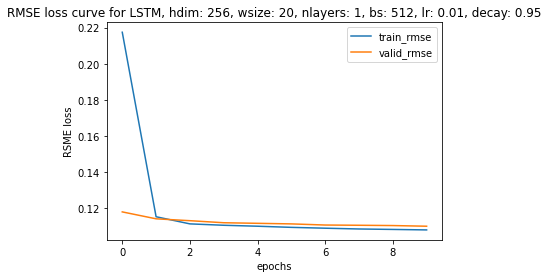

 44%|████▍     | 154/352 [01:48<01:45,  1.88it/s]


 88%|████████▊ | 308/352 [03:41<00:26,  1.67it/s]


100%|██████████| 352/352 [04:04<00:00,  1.44it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765]
0.10981
Epoch 11 | T: 4.67 | Train RMSE: 0.10765 | Valid RMSE: 0.10981


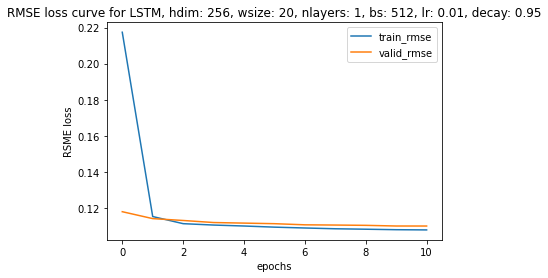

 44%|████▍     | 154/352 [01:36<01:39,  1.98it/s]


 88%|████████▊ | 308/352 [03:30<00:23,  1.86it/s]


100%|██████████| 352/352 [04:07<00:00,  1.42it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745]
0.10986
Epoch 12 | T: 4.58 | Train RMSE: 0.10745 | Valid RMSE: 0.10986


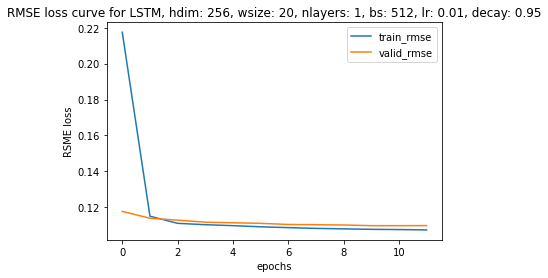

 44%|████▍     | 154/352 [01:50<01:48,  1.82it/s]


 88%|████████▊ | 308/352 [03:44<00:21,  2.06it/s]


100%|██████████| 352/352 [04:16<00:00,  1.37it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733]
0.10984
Epoch 13 | T: 4.75 | Train RMSE: 0.10733 | Valid RMSE: 0.10984


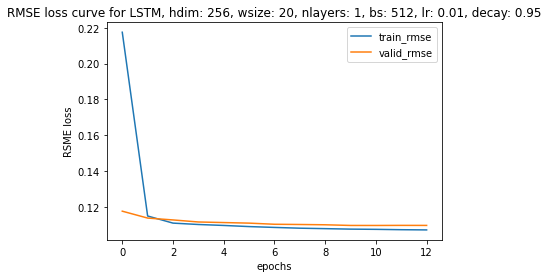

 44%|████▍     | 154/352 [01:53<01:42,  1.93it/s]


 88%|████████▊ | 308/352 [03:42<00:24,  1.81it/s]


100%|██████████| 352/352 [04:04<00:00,  1.44it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723]
0.10978
Epoch 14 | T: 4.70 | Train RMSE: 0.10723 | Valid RMSE: 0.10978


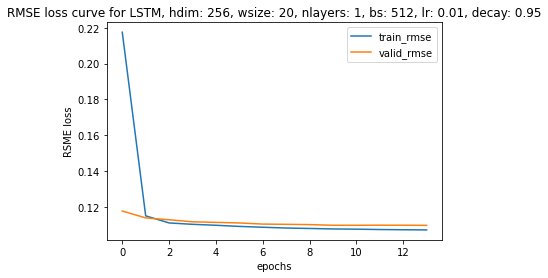

 44%|████▍     | 154/352 [01:36<01:38,  2.01it/s]


 88%|████████▊ | 308/352 [03:29<00:21,  2.08it/s]


100%|██████████| 352/352 [04:01<00:00,  1.46it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712]
0.10952
Epoch 15 | T: 4.48 | Train RMSE: 0.10712 | Valid RMSE: 0.10952


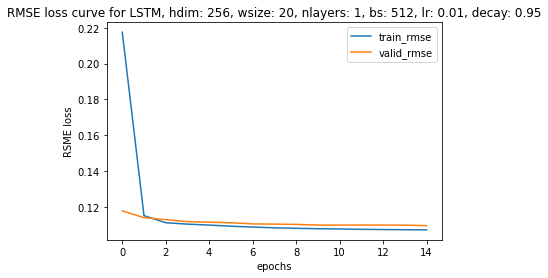

 44%|████▍     | 154/352 [01:54<01:38,  2.01it/s]


 88%|████████▊ | 308/352 [03:45<00:22,  1.96it/s]


100%|██████████| 352/352 [04:07<00:00,  1.42it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707]
0.1095
Epoch 16 | T: 4.74 | Train RMSE: 0.10707 | Valid RMSE: 0.10950


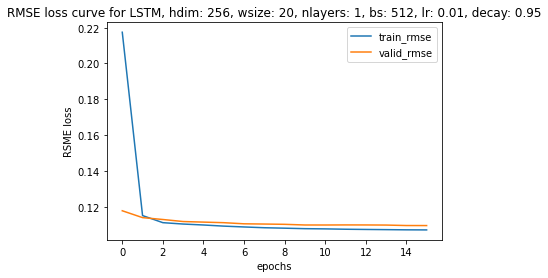

 44%|████▍     | 154/352 [02:00<01:42,  1.94it/s]


 88%|████████▊ | 308/352 [03:40<00:26,  1.69it/s]


100%|██████████| 352/352 [04:03<00:00,  1.45it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694]
0.10961
Epoch 17 | T: 4.71 | Train RMSE: 0.10694 | Valid RMSE: 0.10961


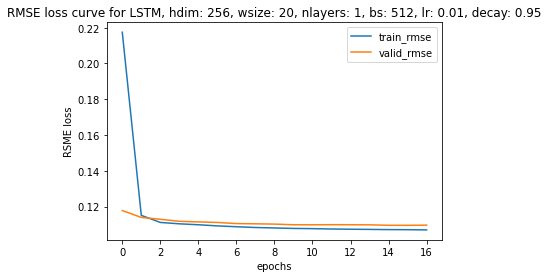

 44%|████▍     | 154/352 [01:42<01:40,  1.97it/s]


 88%|████████▊ | 308/352 [03:32<00:22,  2.00it/s]


100%|██████████| 352/352 [04:04<00:00,  1.44it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687]
0.10951
Epoch 18 | T: 4.52 | Train RMSE: 0.10687 | Valid RMSE: 0.10951


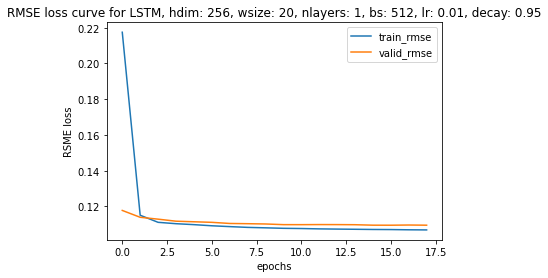

 44%|████▍     | 154/352 [02:01<01:39,  1.99it/s]


 88%|████████▊ | 308/352 [03:41<00:23,  1.87it/s]


100%|██████████| 352/352 [04:04<00:00,  1.44it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679]
0.1091
Epoch 19 | T: 4.71 | Train RMSE: 0.10679 | Valid RMSE: 0.10910


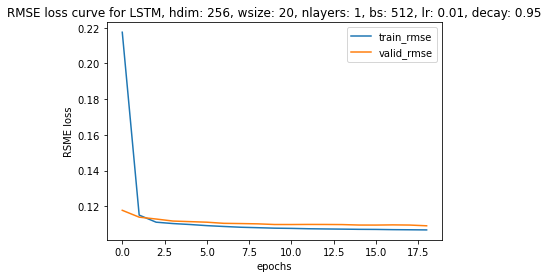

 44%|████▍     | 154/352 [02:07<01:44,  1.89it/s]


 88%|████████▊ | 308/352 [03:41<01:43,  2.34s/it]


100%|██████████| 352/352 [04:02<00:00,  1.45it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671]
0.10931
Epoch 20 | T: 4.45 | Train RMSE: 0.10671 | Valid RMSE: 0.10931


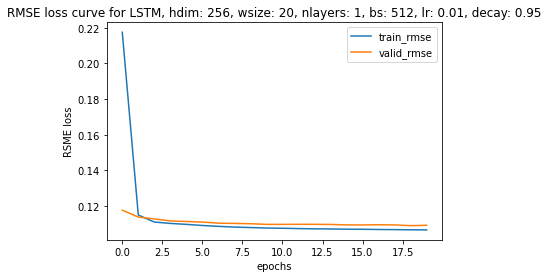

 44%|████▍     | 154/352 [02:23<05:23,  1.63s/it]


 88%|████████▊ | 308/352 [03:45<00:22,  1.98it/s]


100%|██████████| 352/352 [04:21<00:00,  1.35it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665]
0.10916
Epoch 21 | T: 4.77 | Train RMSE: 0.10665 | Valid RMSE: 0.10916


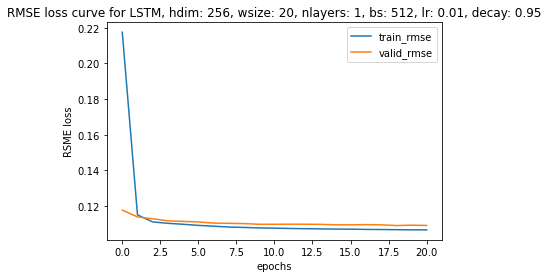

 44%|████▍     | 154/352 [02:06<01:41,  1.95it/s]


 88%|████████▊ | 308/352 [03:43<00:22,  1.94it/s]


100%|██████████| 352/352 [04:05<00:00,  1.44it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662]
0.1093
Epoch 22 | T: 4.78 | Train RMSE: 0.10662 | Valid RMSE: 0.10930


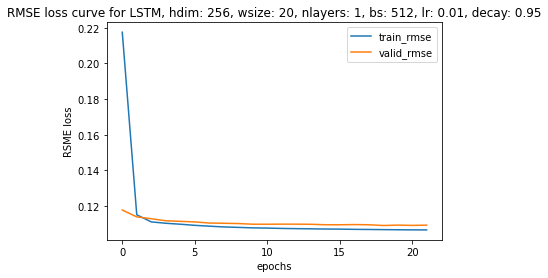

 44%|████▍     | 154/352 [02:05<01:48,  1.83it/s]


 88%|████████▊ | 308/352 [03:30<00:21,  2.07it/s]


100%|██████████| 352/352 [04:02<00:00,  1.45it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647]
0.109
Epoch 23 | T: 4.45 | Train RMSE: 0.10647 | Valid RMSE: 0.10900


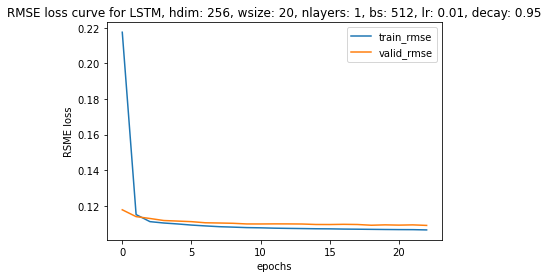

 44%|████▍     | 154/352 [02:23<06:39,  2.02s/it]


 88%|████████▊ | 308/352 [03:44<00:20,  2.20it/s]


100%|██████████| 352/352 [04:05<00:00,  1.43it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644]
0.10923
Epoch 24 | T: 4.76 | Train RMSE: 0.10644 | Valid RMSE: 0.10923


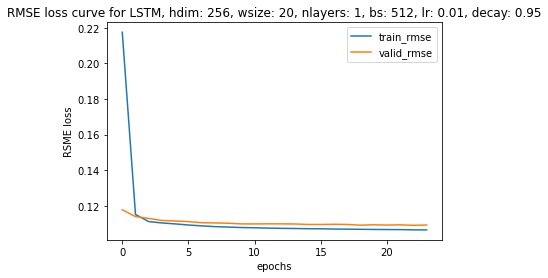

 44%|████▍     | 154/352 [02:08<01:42,  1.93it/s]


 88%|████████▊ | 308/352 [03:40<00:21,  2.07it/s]


100%|██████████| 352/352 [04:01<00:00,  1.45it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636]
0.1089
Epoch 25 | T: 4.76 | Train RMSE: 0.10636 | Valid RMSE: 0.10890


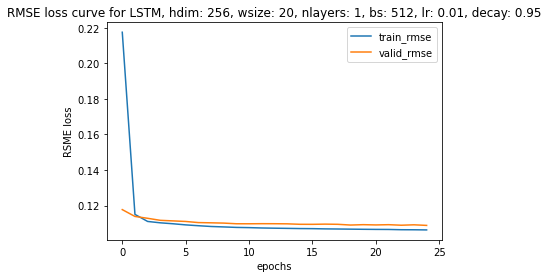

 44%|████▍     | 154/352 [02:06<01:36,  2.06it/s]


 88%|████████▊ | 308/352 [03:24<00:21,  2.08it/s]


100%|██████████| 352/352 [04:00<00:00,  1.46it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063]
0.10899
Epoch 26 | T: 4.41 | Train RMSE: 0.10630 | Valid RMSE: 0.10899


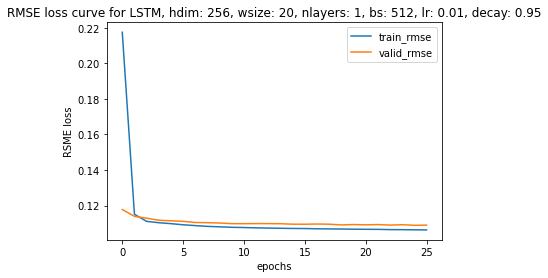

 44%|████▍     | 154/352 [02:09<01:34,  2.09it/s]


 88%|████████▊ | 308/352 [03:39<00:20,  2.19it/s]


100%|██████████| 352/352 [04:00<00:00,  1.47it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622]
0.1089
Epoch 27 | T: 4.72 | Train RMSE: 0.10622 | Valid RMSE: 0.10890


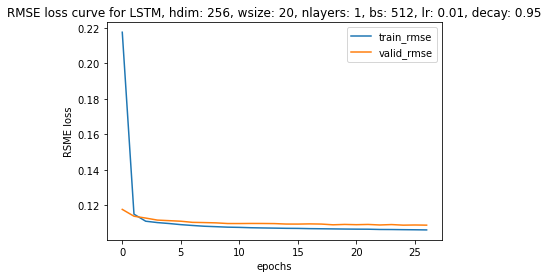

 44%|████▍     | 154/352 [02:07<01:41,  1.95it/s]


 88%|████████▊ | 308/352 [03:28<00:21,  2.04it/s]


100%|██████████| 352/352 [04:02<00:00,  1.45it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062]
0.10898
Epoch 28 | T: 4.44 | Train RMSE: 0.10620 | Valid RMSE: 0.10898


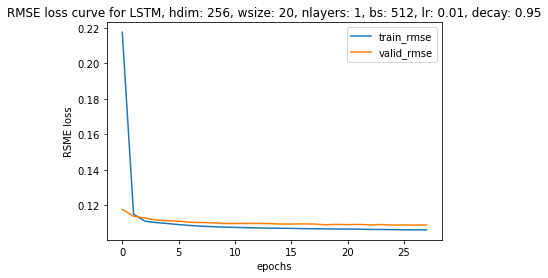

 44%|████▍     | 154/352 [02:21<01:49,  1.82it/s]


 88%|████████▊ | 308/352 [03:43<00:21,  2.02it/s]


100%|██████████| 352/352 [04:22<00:00,  1.34it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061]
0.10889
Epoch 29 | T: 4.79 | Train RMSE: 0.10610 | Valid RMSE: 0.10889


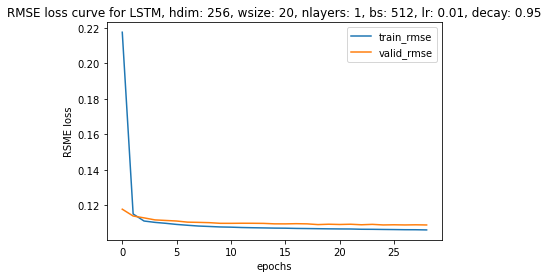

 44%|████▍     | 154/352 [02:10<01:37,  2.03it/s]


 88%|████████▊ | 308/352 [03:40<00:21,  2.06it/s]


100%|██████████| 352/352 [04:00<00:00,  1.46it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605]
0.10886
Epoch 30 | T: 4.86 | Train RMSE: 0.10605 | Valid RMSE: 0.10886


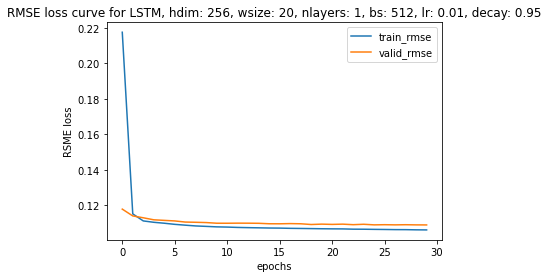

 44%|████▍     | 154/352 [01:55<01:36,  2.06it/s]


 88%|████████▊ | 308/352 [03:16<00:21,  2.06it/s]


100%|██████████| 352/352 [03:54<00:00,  1.50it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603]
0.10883
Epoch 31 | T: 4.32 | Train RMSE: 0.10603 | Valid RMSE: 0.10883


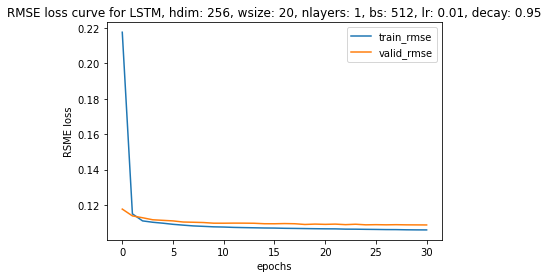

 44%|████▍     | 154/352 [02:15<02:03,  1.60it/s]


 88%|████████▊ | 308/352 [03:42<00:21,  2.06it/s]


100%|██████████| 352/352 [04:03<00:00,  1.45it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594]
0.10896
Epoch 32 | T: 4.86 | Train RMSE: 0.10594 | Valid RMSE: 0.10896


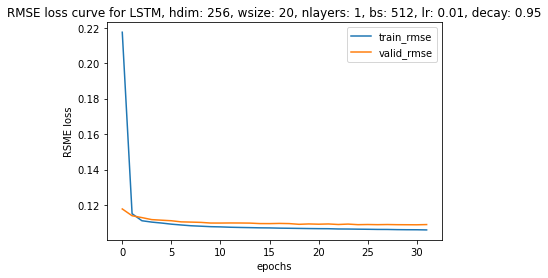

 44%|████▍     | 154/352 [01:57<01:42,  1.94it/s]


 88%|████████▊ | 308/352 [03:35<00:34,  1.28it/s]


100%|██████████| 352/352 [03:57<00:00,  1.48it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587]
0.10886
Epoch 33 | T: 4.89 | Train RMSE: 0.10587 | Valid RMSE: 0.10886


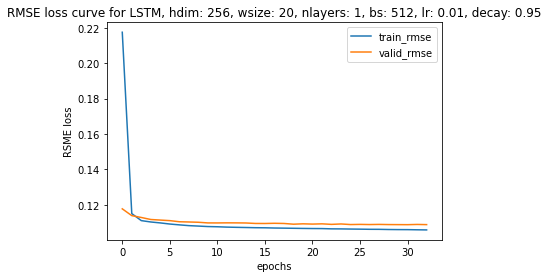

 44%|████▍     | 154/352 [01:46<01:35,  2.08it/s]


 88%|████████▊ | 308/352 [03:13<00:22,  1.96it/s]


100%|██████████| 352/352 [03:56<00:00,  1.49it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582]
0.10888
Epoch 34 | T: 4.35 | Train RMSE: 0.10582 | Valid RMSE: 0.10888


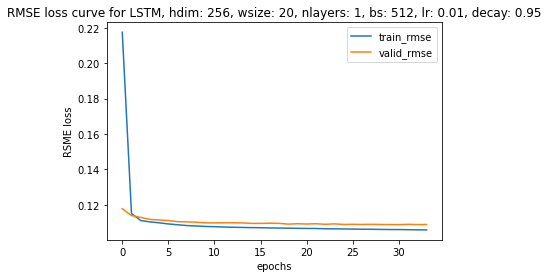

 44%|████▍     | 154/352 [02:00<01:37,  2.04it/s]


 88%|████████▊ | 308/352 [03:37<00:21,  2.00it/s]


100%|██████████| 352/352 [03:57<00:00,  1.48it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573]
0.10893
Epoch 35 | T: 4.87 | Train RMSE: 0.10573 | Valid RMSE: 0.10893


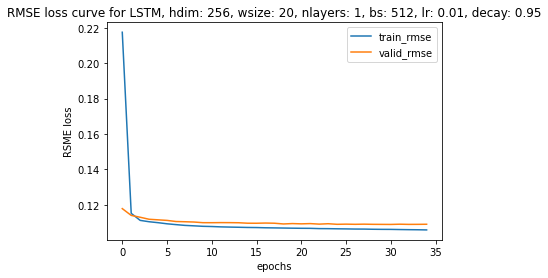

 44%|████▍     | 154/352 [01:48<01:37,  2.04it/s]


 88%|████████▊ | 308/352 [03:36<01:14,  1.68s/it]


100%|██████████| 352/352 [03:57<00:00,  1.48it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057]
0.10914
Epoch 36 | T: 4.83 | Train RMSE: 0.10570 | Valid RMSE: 0.10914


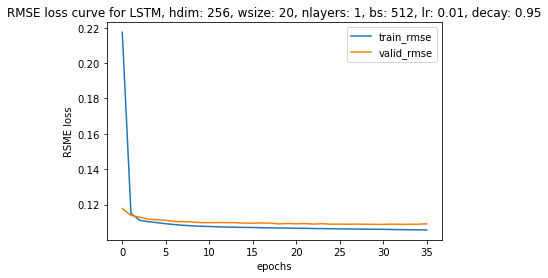

 44%|████▍     | 154/352 [01:39<01:36,  2.06it/s]


 88%|████████▊ | 308/352 [03:08<00:21,  2.07it/s]


100%|██████████| 352/352 [04:01<00:00,  1.46it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563]
0.10889
Epoch 37 | T: 4.71 | Train RMSE: 0.10563 | Valid RMSE: 0.10889


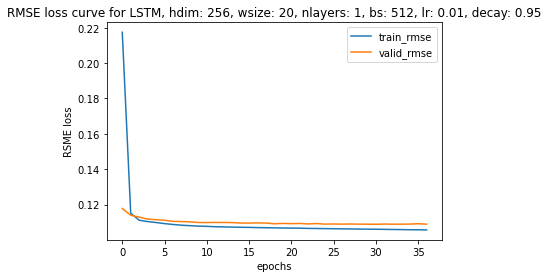

 44%|████▍     | 154/352 [01:24<01:33,  2.12it/s]


 88%|████████▊ | 308/352 [03:18<00:21,  2.04it/s]


100%|██████████| 352/352 [04:01<00:00,  1.46it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559]
0.10891
Epoch 38 | T: 4.45 | Train RMSE: 0.10559 | Valid RMSE: 0.10891


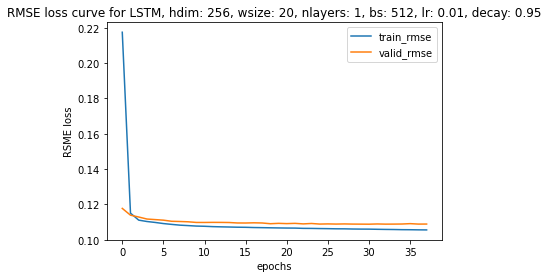

 44%|████▍     | 154/352 [01:44<01:39,  1.99it/s]


 88%|████████▊ | 308/352 [03:37<02:05,  2.85s/it]


100%|██████████| 352/352 [03:58<00:00,  1.48it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553]
0.10881
Epoch 39 | T: 4.68 | Train RMSE: 0.10553 | Valid RMSE: 0.10881


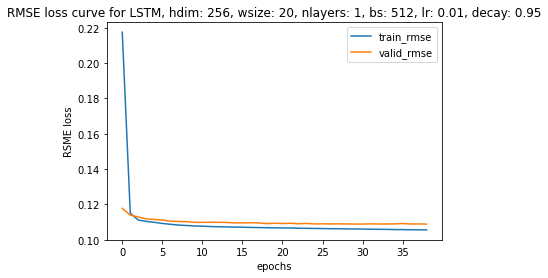

 44%|████▍     | 154/352 [01:30<01:34,  2.10it/s]


 88%|████████▊ | 308/352 [03:16<00:21,  2.03it/s]


100%|██████████| 352/352 [03:59<00:00,  1.47it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546]
0.10887
Epoch 40 | T: 4.39 | Train RMSE: 0.10546 | Valid RMSE: 0.10887


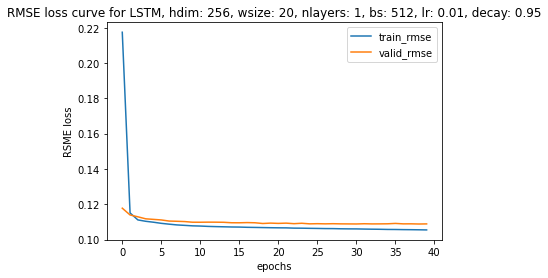

 44%|████▍     | 154/352 [01:46<01:32,  2.15it/s]


 88%|████████▊ | 308/352 [03:39<00:31,  1.40it/s]


100%|██████████| 352/352 [04:01<00:00,  1.46it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543]
0.10893
Epoch 41 | T: 4.73 | Train RMSE: 0.10543 | Valid RMSE: 0.10893


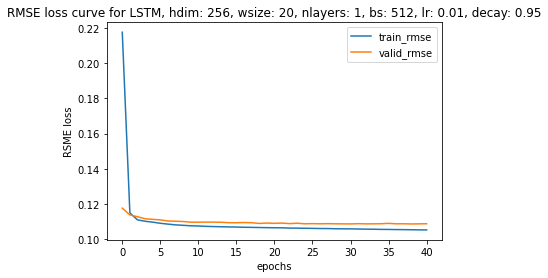

 44%|████▍     | 154/352 [01:43<05:39,  1.71s/it]


 88%|████████▊ | 308/352 [03:20<00:21,  2.02it/s]


100%|██████████| 352/352 [04:00<00:00,  1.47it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533]
0.10877
Epoch 42 | T: 4.61 | Train RMSE: 0.10533 | Valid RMSE: 0.10877


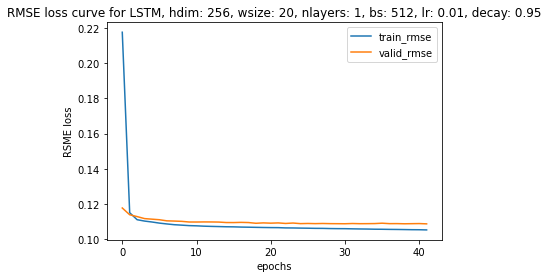

 44%|████▍     | 154/352 [01:34<01:38,  2.01it/s]


 88%|████████▊ | 308/352 [03:29<00:22,  1.98it/s]


100%|██████████| 352/352 [04:07<00:00,  1.42it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053]
0.10902
Epoch 43 | T: 4.55 | Train RMSE: 0.10530 | Valid RMSE: 0.10902


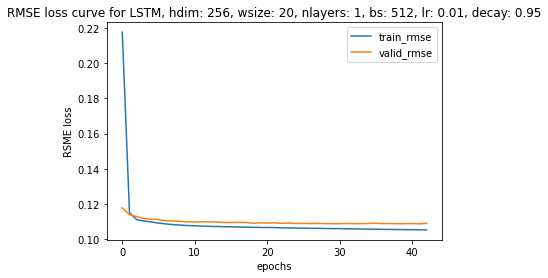

 44%|████▍     | 154/352 [01:50<01:40,  1.96it/s]


 88%|████████▊ | 308/352 [03:42<00:27,  1.58it/s]


100%|██████████| 352/352 [04:04<00:00,  1.44it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522]
0.1088
Epoch 44 | T: 4.69 | Train RMSE: 0.10522 | Valid RMSE: 0.10880


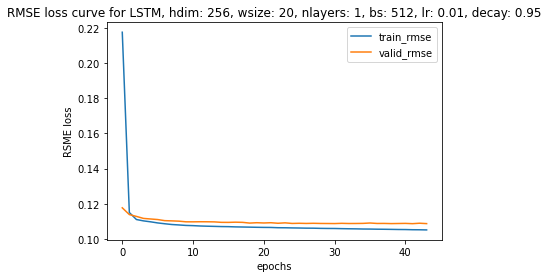

 44%|████▍     | 154/352 [01:34<01:33,  2.11it/s]


 88%|████████▊ | 308/352 [03:30<00:21,  2.06it/s]


100%|██████████| 352/352 [04:07<00:00,  1.42it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516]
0.10884
Epoch 45 | T: 4.52 | Train RMSE: 0.10516 | Valid RMSE: 0.10884


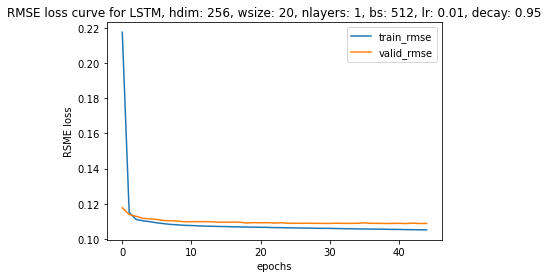

 44%|████▍     | 154/352 [01:51<01:34,  2.10it/s]


 88%|████████▊ | 308/352 [03:40<00:21,  2.01it/s]


100%|██████████| 352/352 [04:01<00:00,  1.46it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509]
0.10889
Epoch 46 | T: 4.63 | Train RMSE: 0.10509 | Valid RMSE: 0.10889


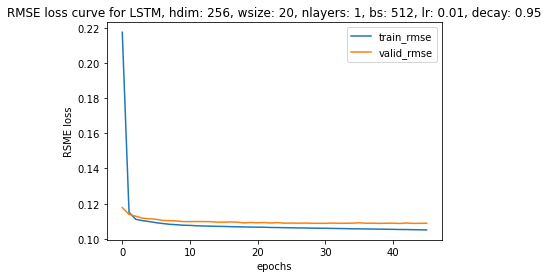

 44%|████▍     | 154/352 [01:58<01:42,  1.93it/s]


 88%|████████▊ | 308/352 [03:42<01:52,  2.57s/it]


100%|██████████| 352/352 [04:04<00:00,  1.44it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505]
0.10886
Epoch 47 | T: 4.71 | Train RMSE: 0.10505 | Valid RMSE: 0.10886


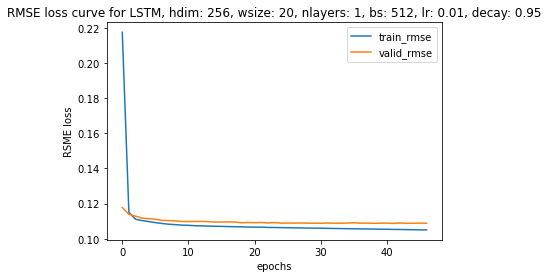

 44%|████▍     | 154/352 [01:40<01:35,  2.07it/s]


 88%|████████▊ | 308/352 [03:28<00:21,  2.05it/s]


100%|██████████| 352/352 [04:02<00:00,  1.45it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497]
0.10886
Epoch 48 | T: 4.46 | Train RMSE: 0.10497 | Valid RMSE: 0.10886


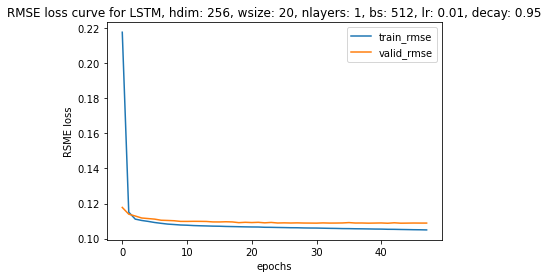

 44%|████▍     | 154/352 [01:55<01:41,  1.95it/s]


 88%|████████▊ | 308/352 [03:42<00:20,  2.15it/s]


100%|██████████| 352/352 [04:03<00:00,  1.44it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495]
0.10897
Epoch 49 | T: 4.68 | Train RMSE: 0.10495 | Valid RMSE: 0.10897


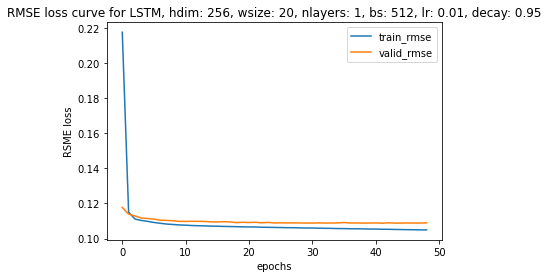

 44%|████▍     | 154/352 [01:58<10:59,  3.33s/it]


 88%|████████▊ | 308/352 [03:27<00:22,  1.98it/s]


100%|██████████| 352/352 [04:02<00:00,  1.45it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487]
0.10893
Epoch 50 | T: 4.44 | Train RMSE: 0.10487 | Valid RMSE: 0.10893


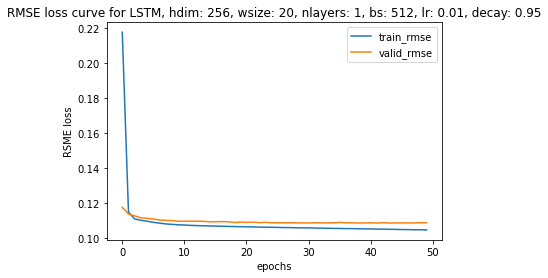

 44%|████▍     | 154/352 [01:55<01:39,  1.99it/s]


 88%|████████▊ | 308/352 [03:42<00:22,  1.98it/s]


100%|██████████| 352/352 [04:03<00:00,  1.44it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481]
0.10901
Epoch 51 | T: 4.70 | Train RMSE: 0.10481 | Valid RMSE: 0.10901


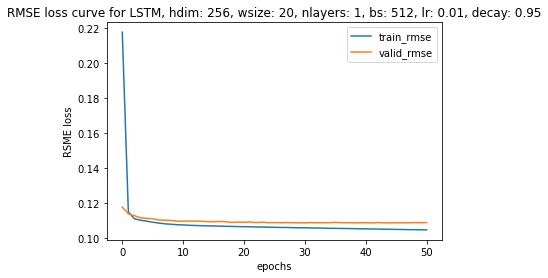

 44%|████▍     | 154/352 [01:55<02:13,  1.48it/s]


 88%|████████▊ | 308/352 [03:28<00:20,  2.10it/s]


100%|██████████| 352/352 [04:04<00:00,  1.44it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049]
0.10892
Epoch 52 | T: 4.48 | Train RMSE: 0.10490 | Valid RMSE: 0.10892


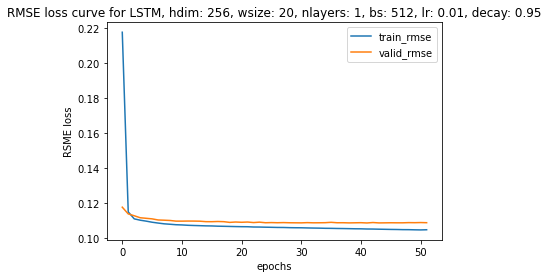

 44%|████▍     | 154/352 [01:51<01:32,  2.13it/s]


 88%|████████▊ | 308/352 [03:44<00:22,  2.00it/s]


100%|██████████| 352/352 [04:15<00:00,  1.38it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478]
0.109
Epoch 53 | T: 4.67 | Train RMSE: 0.10478 | Valid RMSE: 0.10900


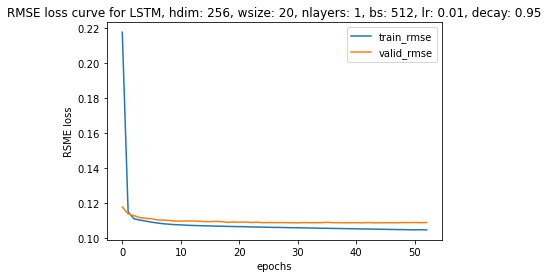

 44%|████▍     | 154/352 [02:01<01:43,  1.91it/s]


 60%|█████▉    | 210/352 [02:45<01:32,  1.54it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 352/352 [04:04<00:00,  1.44it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455]
0.10908
Epoch 57 | T: 4.74 | Train RMSE: 0.10455 | Valid RMSE: 0.10908


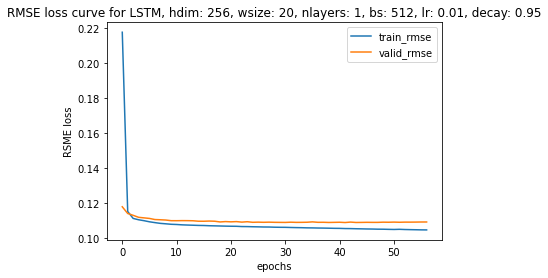

 44%|████▍     | 154/352 [01:38<01:39,  1.99it/s]


 88%|████████▊ | 308/352 [03:29<00:19,  2.29it/s]


100%|██████████| 352/352 [04:01<00:00,  1.46it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452]
0.10918
Epoch 58 | T: 4.42 | Train RMSE: 0.10452 | Valid RMSE: 0.10918


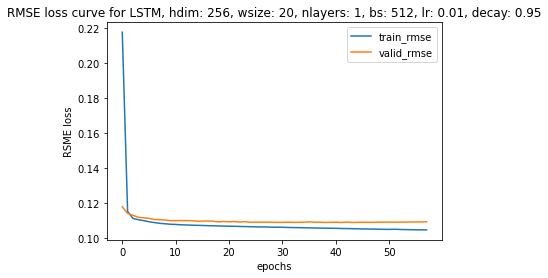

 44%|████▍     | 154/352 [02:00<01:35,  2.06it/s]


 88%|████████▊ | 308/352 [03:41<00:21,  2.06it/s]


100%|██████████| 352/352 [04:03<00:00,  1.45it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448]
0.10917
Epoch 59 | T: 4.72 | Train RMSE: 0.10448 | Valid RMSE: 0.10917


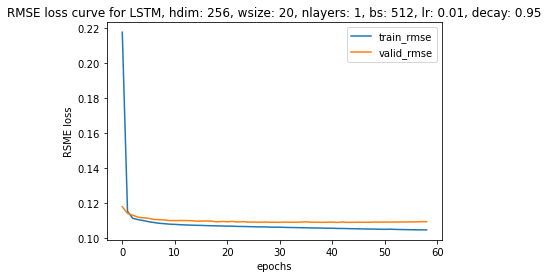

 44%|████▍     | 154/352 [02:04<01:51,  1.78it/s]


 88%|████████▊ | 308/352 [03:27<00:20,  2.18it/s]


100%|██████████| 352/352 [04:00<00:00,  1.46it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444]
0.10918
Epoch 60 | T: 4.42 | Train RMSE: 0.10444 | Valid RMSE: 0.10918


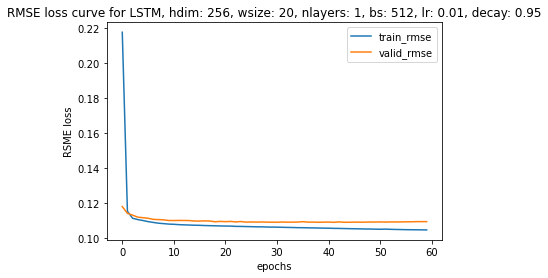

 44%|████▍     | 154/352 [02:00<01:36,  2.05it/s]


 88%|████████▊ | 308/352 [03:46<00:21,  2.05it/s]


100%|██████████| 352/352 [04:06<00:00,  1.43it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044]
0.10922
Epoch 61 | T: 4.73 | Train RMSE: 0.10440 | Valid RMSE: 0.10922


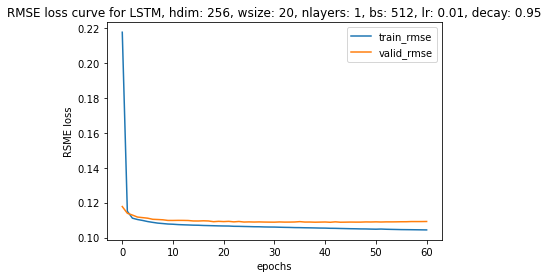

 44%|████▍     | 154/352 [02:03<01:39,  1.99it/s]


 88%|████████▊ | 308/352 [03:38<00:24,  1.76it/s]


100%|██████████| 352/352 [04:00<00:00,  1.46it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434]
0.1092
Epoch 62 | T: 4.39 | Train RMSE: 0.10434 | Valid RMSE: 0.10920


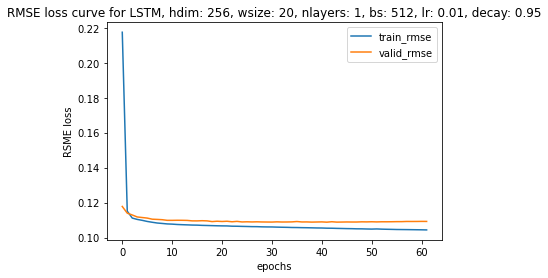

 44%|████▍     | 154/352 [02:23<21:36,  6.55s/it]


 88%|████████▊ | 308/352 [03:45<00:20,  2.16it/s]


100%|██████████| 352/352 [04:18<00:00,  1.36it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431]
0.1092
Epoch 63 | T: 4.73 | Train RMSE: 0.10431 | Valid RMSE: 0.10920


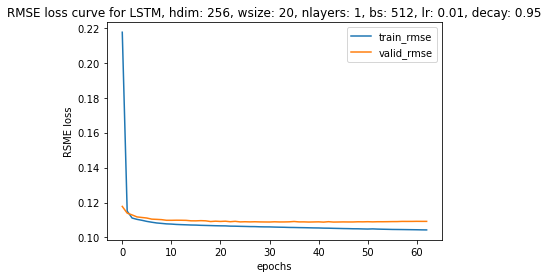

 44%|████▍     | 154/352 [02:09<01:38,  2.01it/s]


 88%|████████▊ | 308/352 [03:41<00:20,  2.10it/s]


100%|██████████| 352/352 [04:02<00:00,  1.45it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427]
0.10936
Epoch 64 | T: 4.75 | Train RMSE: 0.10427 | Valid RMSE: 0.10936


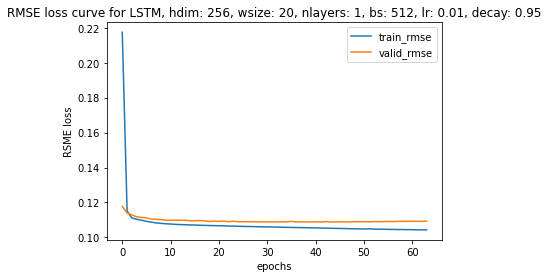

 44%|████▍     | 154/352 [02:06<01:37,  2.04it/s]


 88%|████████▊ | 308/352 [03:29<00:22,  1.95it/s]


100%|██████████| 352/352 [04:02<00:00,  1.45it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427, 0.10425]
0.10935
Epoch 65 | T: 4.43 | Train RMSE: 0.10425 | Valid RMSE: 0.10935


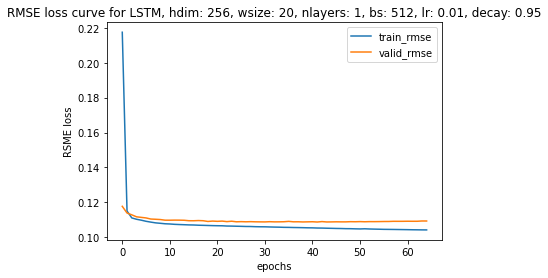

 44%|████▍     | 154/352 [02:03<01:36,  2.06it/s]


 88%|████████▊ | 308/352 [03:43<00:21,  2.09it/s]


100%|██████████| 352/352 [04:05<00:00,  1.44it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427, 0.10425, 0.10421]
0.10938
Epoch 66 | T: 4.71 | Train RMSE: 0.10421 | Valid RMSE: 0.10938


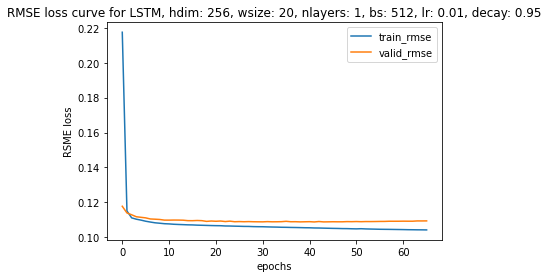

 44%|████▍     | 154/352 [02:08<01:32,  2.14it/s]


 88%|████████▊ | 308/352 [03:39<00:27,  1.63it/s]


100%|██████████| 352/352 [04:00<00:00,  1.47it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427, 0.10425, 0.10421, 0.10419]
0.10935
Epoch 67 | T: 4.39 | Train RMSE: 0.10419 | Valid RMSE: 0.10935


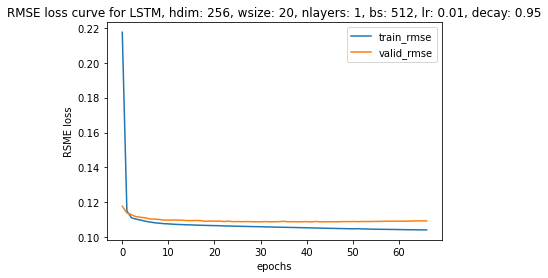

 44%|████▍     | 154/352 [02:24<02:57,  1.11it/s]


 88%|████████▊ | 308/352 [03:43<00:20,  2.18it/s]


100%|██████████| 352/352 [04:03<00:00,  1.44it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427, 0.10425, 0.10421, 0.10419, 0.10414]
0.10947
Epoch 68 | T: 4.72 | Train RMSE: 0.10414 | Valid RMSE: 0.10947


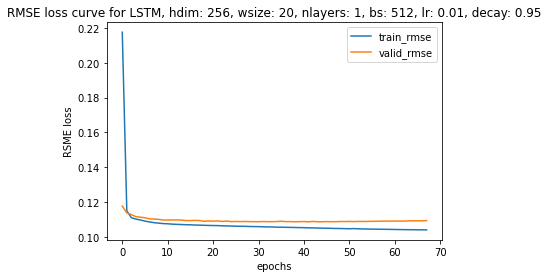

 44%|████▍     | 154/352 [02:05<01:34,  2.10it/s]


 88%|████████▊ | 308/352 [03:38<00:23,  1.85it/s]


100%|██████████| 352/352 [03:59<00:00,  1.47it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427, 0.10425, 0.10421, 0.10419, 0.10414, 0.10414]
0.10942
Epoch 69 | T: 4.70 | Train RMSE: 0.10414 | Valid RMSE: 0.10942


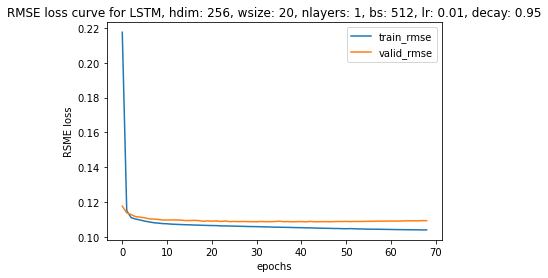

 44%|████▍     | 154/352 [02:04<02:25,  1.36it/s]


 88%|████████▊ | 308/352 [03:24<00:21,  2.05it/s]


100%|██████████| 352/352 [03:58<00:00,  1.48it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427, 0.10425, 0.10421, 0.10419, 0.10414, 0.10414, 0.10409]
0.10938
Epoch 70 | T: 4.38 | Train RMSE: 0.10409 | Valid RMSE: 0.10938


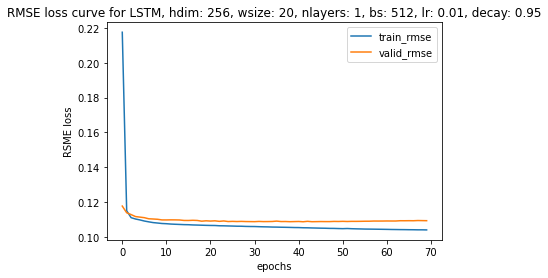

 44%|████▍     | 154/352 [02:10<01:38,  2.02it/s]


 88%|████████▊ | 308/352 [03:39<00:19,  2.26it/s]


100%|██████████| 352/352 [03:59<00:00,  1.47it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427, 0.10425, 0.10421, 0.10419, 0.10414, 0.10414, 0.10409, 0.10406]
0.10948
Epoch 71 | T: 4.71 | Train RMSE: 0.10406 | Valid RMSE: 0.10948


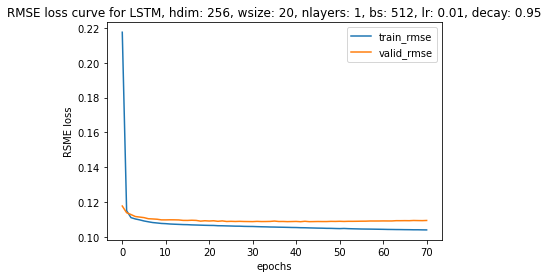

 44%|████▍     | 154/352 [02:05<01:32,  2.14it/s]


 88%|████████▊ | 308/352 [03:23<00:19,  2.26it/s]


100%|██████████| 352/352 [03:59<00:00,  1.47it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427, 0.10425, 0.10421, 0.10419, 0.10414, 0.10414, 0.10409, 0.10406, 0.10404]
0.10945
Epoch 72 | T: 4.40 | Train RMSE: 0.10404 | Valid RMSE: 0.10945


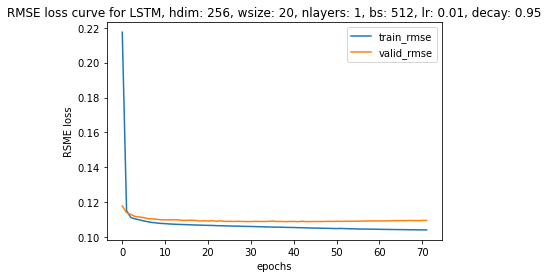

 44%|████▍     | 154/352 [02:06<01:34,  2.08it/s]


 88%|████████▊ | 308/352 [03:39<00:21,  2.05it/s]


100%|██████████| 352/352 [03:59<00:00,  1.47it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427, 0.10425, 0.10421, 0.10419, 0.10414, 0.10414, 0.10409, 0.10406, 0.10404, 0.10402]
0.10947
Epoch 73 | T: 4.66 | Train RMSE: 0.10402 | Valid RMSE: 0.10947


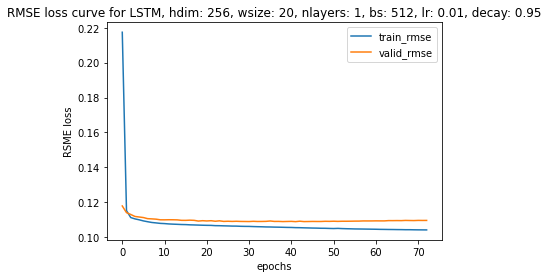

 44%|████▍     | 154/352 [02:09<01:42,  1.93it/s]


 88%|████████▊ | 308/352 [03:26<00:20,  2.14it/s]


100%|██████████| 352/352 [04:01<00:00,  1.46it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427, 0.10425, 0.10421, 0.10419, 0.10414, 0.10414, 0.10409, 0.10406, 0.10404, 0.10402, 0.10398]
0.10944
Epoch 74 | T: 4.42 | Train RMSE: 0.10398 | Valid RMSE: 0.10944


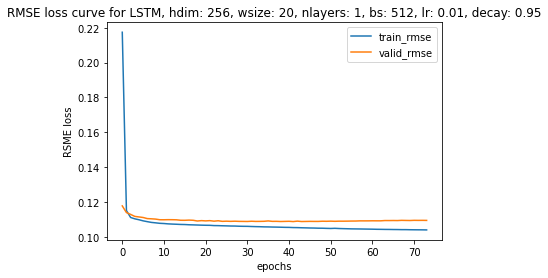

 44%|████▍     | 154/352 [02:07<01:28,  2.24it/s]


 88%|████████▊ | 308/352 [03:41<00:20,  2.13it/s]


100%|██████████| 352/352 [04:01<00:00,  1.46it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427, 0.10425, 0.10421, 0.10419, 0.10414, 0.10414, 0.10409, 0.10406, 0.10404, 0.10402, 0.10398, 0.10395]
0.10953
Epoch 75 | T: 4.73 | Train RMSE: 0.10395 | Valid RMSE: 0.10953


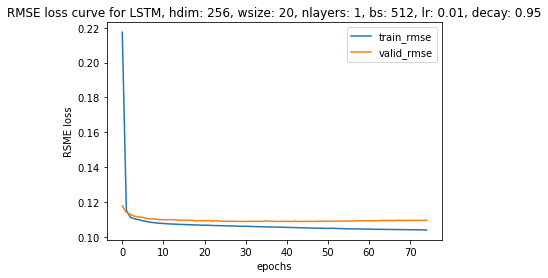

 44%|████▍     | 154/352 [02:07<01:34,  2.10it/s]


 88%|████████▊ | 308/352 [03:23<00:20,  2.19it/s]


100%|██████████| 352/352 [03:58<00:00,  1.48it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427, 0.10425, 0.10421, 0.10419, 0.10414, 0.10414, 0.10409, 0.10406, 0.10404, 0.10402, 0.10398, 0.10395, 0.10393]
0.10949
Epoch 76 | T: 4.35 | Train RMSE: 0.10393 | Valid RMSE: 0.10949


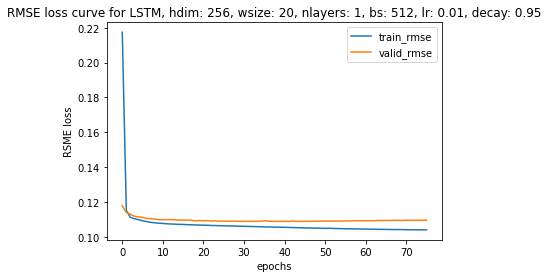

 44%|████▍     | 154/352 [02:21<01:33,  2.12it/s]


 88%|████████▊ | 308/352 [03:40<00:20,  2.18it/s]


100%|██████████| 352/352 [03:59<00:00,  1.47it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427, 0.10425, 0.10421, 0.10419, 0.10414, 0.10414, 0.10409, 0.10406, 0.10404, 0.10402, 0.10398, 0.10395, 0.10393, 0.10392]
0.10961
Epoch 77 | T: 4.72 | Train RMSE: 0.10392 | Valid RMSE: 0.10961


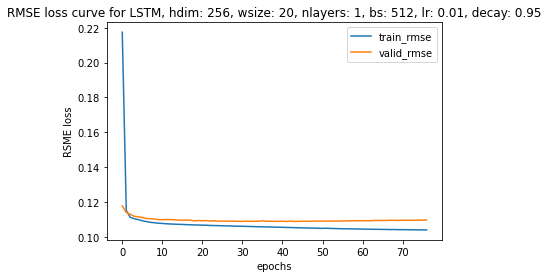

 44%|████▍     | 154/352 [02:10<01:38,  2.00it/s]


 88%|████████▊ | 308/352 [03:41<00:21,  2.00it/s]


100%|██████████| 352/352 [04:02<00:00,  1.45it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427, 0.10425, 0.10421, 0.10419, 0.10414, 0.10414, 0.10409, 0.10406, 0.10404, 0.10402, 0.10398, 0.10395, 0.10393, 0.10392, 0.10388]
0.1096
Epoch 78 | T: 4.93 | Train RMSE: 0.10388 | Valid RMSE: 0.10960


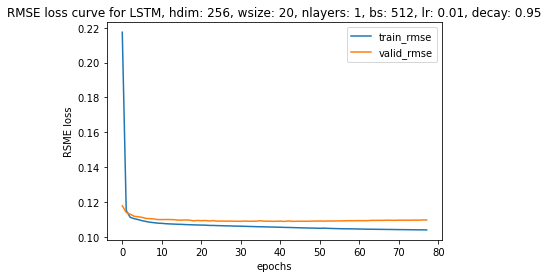

 44%|████▍     | 154/352 [01:51<01:35,  2.06it/s]


 88%|████████▊ | 308/352 [03:10<00:20,  2.18it/s]


100%|██████████| 352/352 [03:50<00:00,  1.53it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427, 0.10425, 0.10421, 0.10419, 0.10414, 0.10414, 0.10409, 0.10406, 0.10404, 0.10402, 0.10398, 0.10395, 0.10393, 0.10392, 0.10388, 0.10388]
0.10954
Epoch 79 | T: 4.25 | Train RMSE: 0.10388 | Valid RMSE: 0.10954


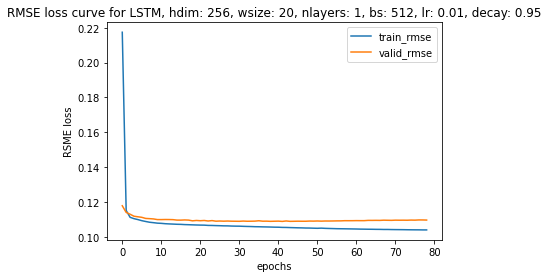

 44%|████▍     | 154/352 [02:06<01:33,  2.11it/s]


 88%|████████▊ | 308/352 [03:39<00:21,  2.09it/s]


100%|██████████| 352/352 [03:59<00:00,  1.47it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427, 0.10425, 0.10421, 0.10419, 0.10414, 0.10414, 0.10409, 0.10406, 0.10404, 0.10402, 0.10398, 0.10395, 0.10393, 0.10392, 0.10388, 0.10388, 0.10385]
0.10963
Epoch 80 | T: 4.95 | Train RMSE: 0.10385 | Valid RMSE: 0.10963


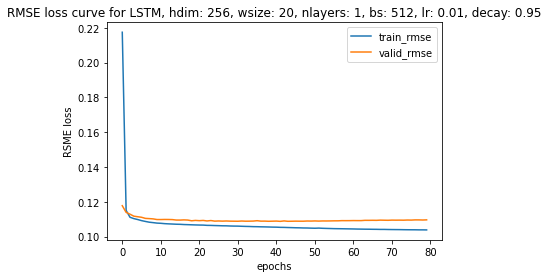

 44%|████▍     | 154/352 [01:45<01:35,  2.08it/s]


 88%|████████▊ | 308/352 [03:08<00:20,  2.13it/s]


100%|██████████| 352/352 [03:50<00:00,  1.53it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427, 0.10425, 0.10421, 0.10419, 0.10414, 0.10414, 0.10409, 0.10406, 0.10404, 0.10402, 0.10398, 0.10395, 0.10393, 0.10392, 0.10388, 0.10388, 0.10385, 0.10384]
0.10969
Epoch 81 | T: 4.23 | Train RMSE: 0.10384 | Valid RMSE: 0.10969


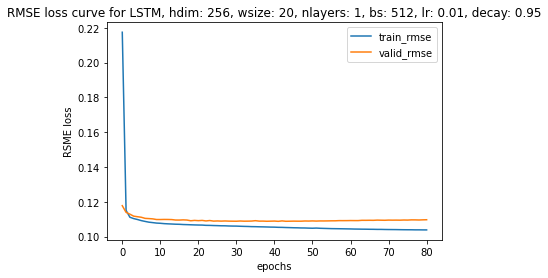

 44%|████▍     | 154/352 [02:12<01:56,  1.71it/s]


 88%|████████▊ | 308/352 [03:38<00:19,  2.23it/s]


100%|██████████| 352/352 [03:59<00:00,  1.47it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427, 0.10425, 0.10421, 0.10419, 0.10414, 0.10414, 0.10409, 0.10406, 0.10404, 0.10402, 0.10398, 0.10395, 0.10393, 0.10392, 0.10388, 0.10388, 0.10385, 0.10384, 0.10381]
0.1097
Epoch 82 | T: 4.87 | Train RMSE: 0.10381 | Valid RMSE: 0.10970


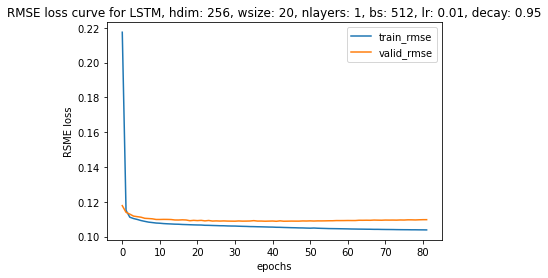

 44%|████▍     | 154/352 [01:48<01:34,  2.08it/s]


 88%|████████▊ | 308/352 [03:08<00:20,  2.19it/s]


100%|██████████| 352/352 [03:54<00:00,  1.50it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427, 0.10425, 0.10421, 0.10419, 0.10414, 0.10414, 0.10409, 0.10406, 0.10404, 0.10402, 0.10398, 0.10395, 0.10393, 0.10392, 0.10388, 0.10388, 0.10385, 0.10384, 0.10381, 0.1038]
0.10962
Epoch 83 | T: 4.80 | Train RMSE: 0.10380 | Valid RMSE: 0.10962


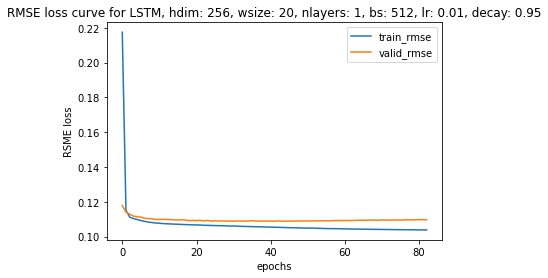

 44%|████▍     | 154/352 [01:36<01:46,  1.86it/s]


 88%|████████▊ | 308/352 [03:07<00:22,  1.96it/s]


100%|██████████| 352/352 [03:56<00:00,  1.49it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427, 0.10425, 0.10421, 0.10419, 0.10414, 0.10414, 0.10409, 0.10406, 0.10404, 0.10402, 0.10398, 0.10395, 0.10393, 0.10392, 0.10388, 0.10388, 0.10385, 0.10384, 0.10381, 0.1038, 0.10377]
0.10963
Epoch 84 | T: 4.33 | Train RMSE: 0.10377 | Valid RMSE: 0.10963


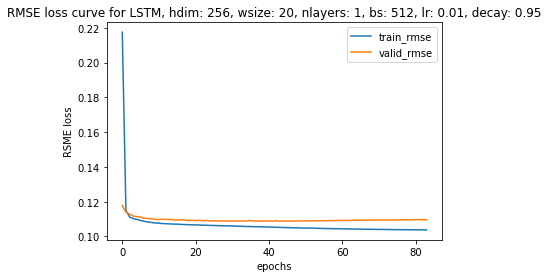

 44%|████▍     | 154/352 [01:44<01:28,  2.23it/s]


 88%|████████▊ | 308/352 [03:33<00:21,  2.05it/s]


100%|██████████| 352/352 [03:53<00:00,  1.51it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427, 0.10425, 0.10421, 0.10419, 0.10414, 0.10414, 0.10409, 0.10406, 0.10404, 0.10402, 0.10398, 0.10395, 0.10393, 0.10392, 0.10388, 0.10388, 0.10385, 0.10384, 0.10381, 0.1038, 0.10377, 0.10377]
0.10967
Epoch 85 | T: 4.69 | Train RMSE: 0.10377 | Valid RMSE: 0.10967


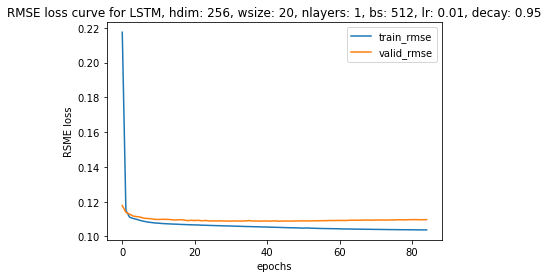

 44%|████▍     | 154/352 [01:43<01:43,  1.91it/s]


 88%|████████▊ | 308/352 [03:14<00:25,  1.75it/s]


100%|██████████| 352/352 [04:02<00:00,  1.45it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427, 0.10425, 0.10421, 0.10419, 0.10414, 0.10414, 0.10409, 0.10406, 0.10404, 0.10402, 0.10398, 0.10395, 0.10393, 0.10392, 0.10388, 0.10388, 0.10385, 0.10384, 0.10381, 0.1038, 0.10377, 0.10377, 0.10376]
0.10973
Epoch 86 | T: 4.72 | Train RMSE: 0.10376 | Valid RMSE: 0.10973


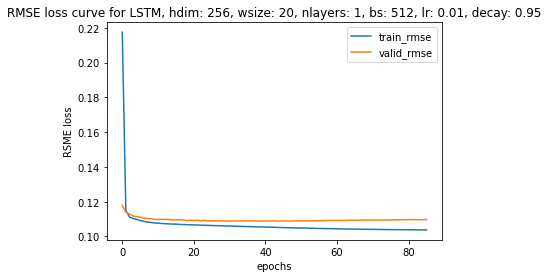

 44%|████▍     | 154/352 [01:29<01:37,  2.04it/s]


 88%|████████▊ | 308/352 [03:20<00:22,  1.97it/s]


100%|██████████| 352/352 [04:03<00:00,  1.45it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427, 0.10425, 0.10421, 0.10419, 0.10414, 0.10414, 0.10409, 0.10406, 0.10404, 0.10402, 0.10398, 0.10395, 0.10393, 0.10392, 0.10388, 0.10388, 0.10385, 0.10384, 0.10381, 0.1038, 0.10377, 0.10377, 0.10376, 0.10373]
0.1097
Epoch 87 | T: 4.48 | Train RMSE: 0.10373 | Valid RMSE: 0.10970


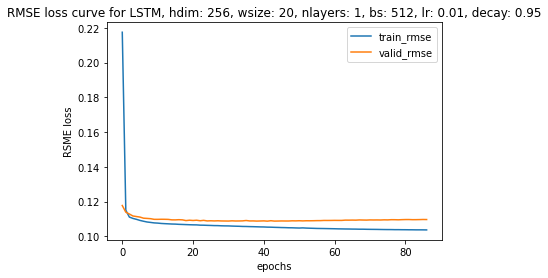

 44%|████▍     | 154/352 [01:47<01:38,  2.02it/s]


 88%|████████▊ | 308/352 [03:41<00:25,  1.71it/s]


100%|██████████| 352/352 [04:03<00:00,  1.45it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427, 0.10425, 0.10421, 0.10419, 0.10414, 0.10414, 0.10409, 0.10406, 0.10404, 0.10402, 0.10398, 0.10395, 0.10393, 0.10392, 0.10388, 0.10388, 0.10385, 0.10384, 0.10381, 0.1038, 0.10377, 0.10377, 0.10376, 0.10373, 0.10372]
0.10973
Epoch 88 | T: 4.77 | Train RMSE: 0.10372 | Valid RMSE: 0.10973


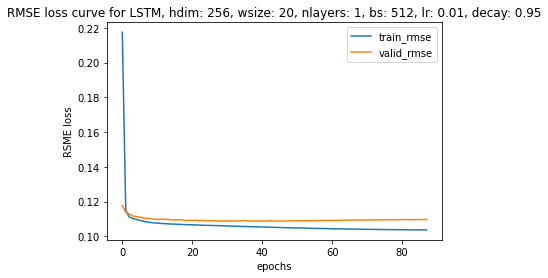

 44%|████▍     | 154/352 [01:50<01:39,  1.98it/s]


 88%|████████▊ | 308/352 [03:24<00:23,  1.87it/s]


100%|██████████| 352/352 [04:07<00:00,  1.42it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427, 0.10425, 0.10421, 0.10419, 0.10414, 0.10414, 0.10409, 0.10406, 0.10404, 0.10402, 0.10398, 0.10395, 0.10393, 0.10392, 0.10388, 0.10388, 0.10385, 0.10384, 0.10381, 0.1038, 0.10377, 0.10377, 0.10376, 0.10373, 0.10372, 0.10371]
0.10978
Epoch 89 | T: 4.79 | Train RMSE: 0.10371 | Valid RMSE: 0.10978


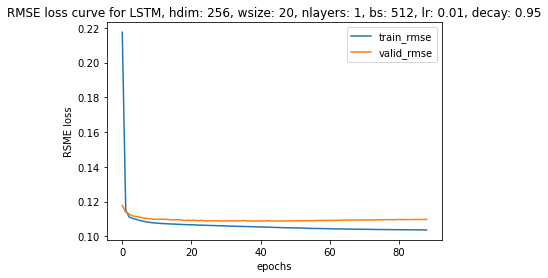

 44%|████▍     | 154/352 [01:33<01:42,  1.93it/s]


 88%|████████▊ | 308/352 [03:28<00:24,  1.80it/s]


100%|██████████| 352/352 [04:07<00:00,  1.42it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427, 0.10425, 0.10421, 0.10419, 0.10414, 0.10414, 0.10409, 0.10406, 0.10404, 0.10402, 0.10398, 0.10395, 0.10393, 0.10392, 0.10388, 0.10388, 0.10385, 0.10384, 0.10381, 0.1038, 0.10377, 0.10377, 0.10376, 0.10373, 0.10372, 0.10371, 0.1037]
0.10972
Epoch 90 | T: 4.55 | Train RMSE: 0.10370 | Valid RMSE: 0.10972


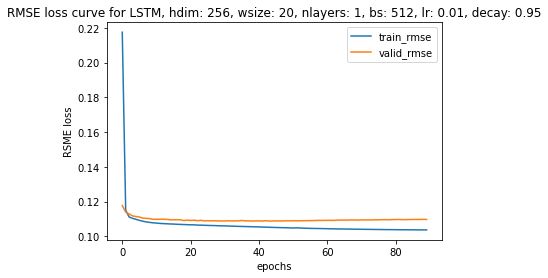

 44%|████▍     | 154/352 [01:50<01:40,  1.96it/s]


 88%|████████▊ | 308/352 [03:41<00:24,  1.83it/s]


100%|██████████| 352/352 [04:02<00:00,  1.45it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427, 0.10425, 0.10421, 0.10419, 0.10414, 0.10414, 0.10409, 0.10406, 0.10404, 0.10402, 0.10398, 0.10395, 0.10393, 0.10392, 0.10388, 0.10388, 0.10385, 0.10384, 0.10381, 0.1038, 0.10377, 0.10377, 0.10376, 0.10373, 0.10372, 0.10371, 0.1037, 0.10371]
0.10981
Epoch 91 | T: 4.70 | Train RMSE: 0.10371 | Valid RMSE: 0.10981


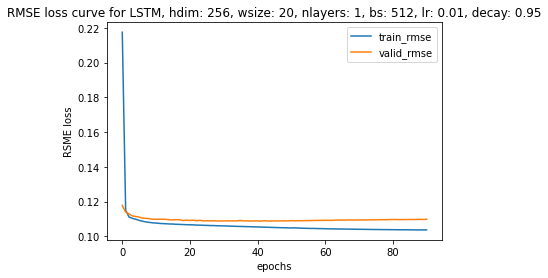

 44%|████▍     | 154/352 [01:55<01:46,  1.86it/s]


 88%|████████▊ | 308/352 [03:44<00:27,  1.57it/s]


100%|██████████| 352/352 [04:06<00:00,  1.43it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427, 0.10425, 0.10421, 0.10419, 0.10414, 0.10414, 0.10409, 0.10406, 0.10404, 0.10402, 0.10398, 0.10395, 0.10393, 0.10392, 0.10388, 0.10388, 0.10385, 0.10384, 0.10381, 0.1038, 0.10377, 0.10377, 0.10376, 0.10373, 0.10372, 0.10371, 0.1037, 0.10371, 0.10367]
0.10984
Epoch 92 | T: 4.74 | Train RMSE: 0.10367 | Valid RMSE: 0.10984


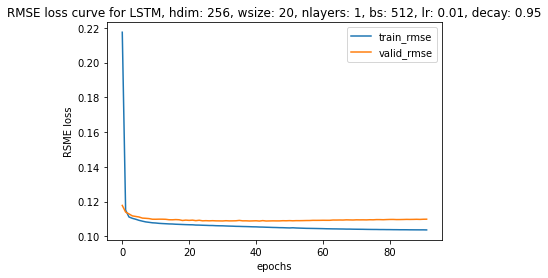

 44%|████▍     | 154/352 [01:38<01:34,  2.11it/s]


 88%|████████▊ | 308/352 [03:28<00:23,  1.89it/s]


100%|██████████| 352/352 [04:05<00:00,  1.44it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427, 0.10425, 0.10421, 0.10419, 0.10414, 0.10414, 0.10409, 0.10406, 0.10404, 0.10402, 0.10398, 0.10395, 0.10393, 0.10392, 0.10388, 0.10388, 0.10385, 0.10384, 0.10381, 0.1038, 0.10377, 0.10377, 0.10376, 0.10373, 0.10372, 0.10371, 0.1037, 0.10371, 0.10367, 0.10366]
0.10977
Epoch 93 | T: 4.51 | Train RMSE: 0.10366 | Valid RMSE: 0.10977


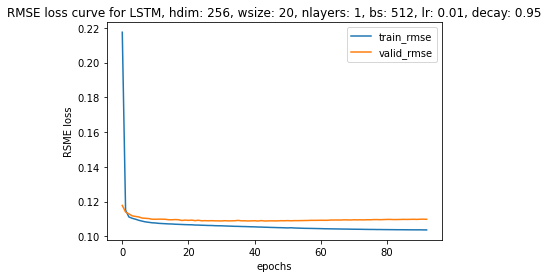

 44%|████▍     | 154/352 [01:54<01:37,  2.04it/s]


 88%|████████▊ | 308/352 [03:45<00:23,  1.86it/s]


100%|██████████| 352/352 [04:07<00:00,  1.42it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427, 0.10425, 0.10421, 0.10419, 0.10414, 0.10414, 0.10409, 0.10406, 0.10404, 0.10402, 0.10398, 0.10395, 0.10393, 0.10392, 0.10388, 0.10388, 0.10385, 0.10384, 0.10381, 0.1038, 0.10377, 0.10377, 0.10376, 0.10373, 0.10372, 0.10371, 0.1037, 0.10371, 0.10367, 0.10366, 0.10365]
0.1098
Epoch 94 | T: 4.75 | Train RMSE: 0.10365 | Valid RMSE: 0.10980


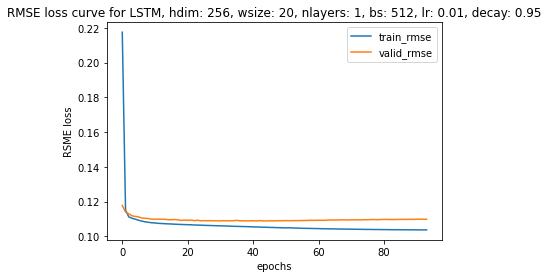

 44%|████▍     | 154/352 [01:56<01:35,  2.08it/s]


 88%|████████▊ | 308/352 [03:44<00:34,  1.27it/s]


100%|██████████| 352/352 [04:05<00:00,  1.43it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427, 0.10425, 0.10421, 0.10419, 0.10414, 0.10414, 0.10409, 0.10406, 0.10404, 0.10402, 0.10398, 0.10395, 0.10393, 0.10392, 0.10388, 0.10388, 0.10385, 0.10384, 0.10381, 0.1038, 0.10377, 0.10377, 0.10376, 0.10373, 0.10372, 0.10371, 0.1037, 0.10371, 0.10367, 0.10366, 0.10365, 0.10365]
0.10987
Epoch 95 | T: 4.72 | Train RMSE: 0.10365 | Valid RMSE: 0.10987


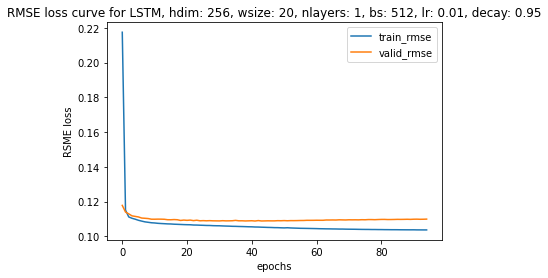

 44%|████▍     | 154/352 [01:39<01:41,  1.96it/s]


 88%|████████▊ | 308/352 [03:32<00:23,  1.91it/s]


100%|██████████| 352/352 [04:04<00:00,  1.44it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427, 0.10425, 0.10421, 0.10419, 0.10414, 0.10414, 0.10409, 0.10406, 0.10404, 0.10402, 0.10398, 0.10395, 0.10393, 0.10392, 0.10388, 0.10388, 0.10385, 0.10384, 0.10381, 0.1038, 0.10377, 0.10377, 0.10376, 0.10373, 0.10372, 0.10371, 0.1037, 0.10371, 0.10367, 0.10366, 0.10365, 0.10365, 0.10364]
0.1098
Epoch 96 | T: 4.48 | Train RMSE: 0.10364 | Valid RMSE: 0.10980


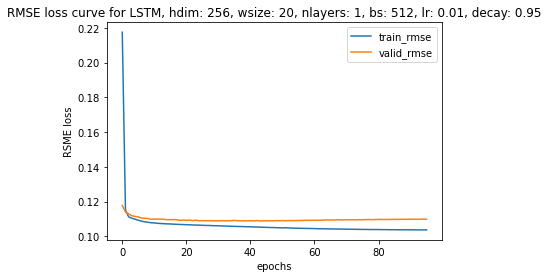

 44%|████▍     | 154/352 [02:02<01:41,  1.96it/s]


 88%|████████▊ | 308/352 [03:45<00:23,  1.89it/s]


100%|██████████| 352/352 [04:06<00:00,  1.43it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427, 0.10425, 0.10421, 0.10419, 0.10414, 0.10414, 0.10409, 0.10406, 0.10404, 0.10402, 0.10398, 0.10395, 0.10393, 0.10392, 0.10388, 0.10388, 0.10385, 0.10384, 0.10381, 0.1038, 0.10377, 0.10377, 0.10376, 0.10373, 0.10372, 0.10371, 0.1037, 0.10371, 0.10367, 0.10366, 0.10365, 0.10365, 0.10364, 0.10364]
0.10984
Epoch 97 | T: 4.78 | Train RMSE: 0.10364 | Valid RMSE: 0.10984


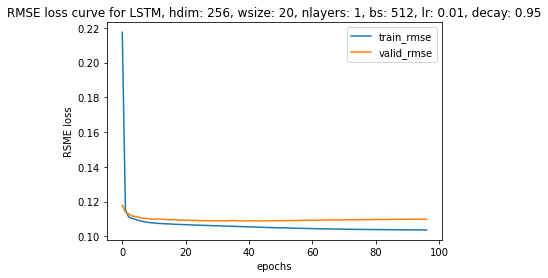

 44%|████▍     | 154/352 [02:00<01:38,  2.00it/s]


 88%|████████▊ | 308/352 [03:41<03:00,  4.11s/it]


100%|██████████| 352/352 [04:03<00:00,  1.45it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427, 0.10425, 0.10421, 0.10419, 0.10414, 0.10414, 0.10409, 0.10406, 0.10404, 0.10402, 0.10398, 0.10395, 0.10393, 0.10392, 0.10388, 0.10388, 0.10385, 0.10384, 0.10381, 0.1038, 0.10377, 0.10377, 0.10376, 0.10373, 0.10372, 0.10371, 0.1037, 0.10371, 0.10367, 0.10366, 0.10365, 0.10365, 0.10364, 0.10364, 0.10361]
0.10984
Epoch 98 | T: 4.47 | Train RMSE: 0.10361 | Valid RMSE: 0.10984


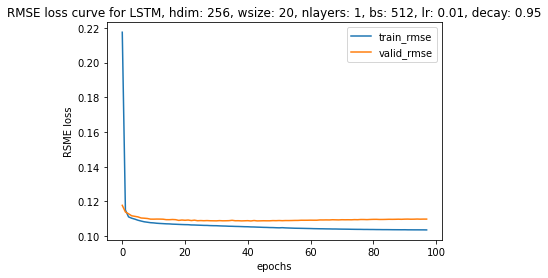

 44%|████▍     | 154/352 [01:58<01:41,  1.95it/s]


 88%|████████▊ | 308/352 [03:48<00:23,  1.86it/s]


100%|██████████| 352/352 [04:20<00:00,  1.35it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427, 0.10425, 0.10421, 0.10419, 0.10414, 0.10414, 0.10409, 0.10406, 0.10404, 0.10402, 0.10398, 0.10395, 0.10393, 0.10392, 0.10388, 0.10388, 0.10385, 0.10384, 0.10381, 0.1038, 0.10377, 0.10377, 0.10376, 0.10373, 0.10372, 0.10371, 0.1037, 0.10371, 0.10367, 0.10366, 0.10365, 0.10365, 0.10364, 0.10364, 0.10361, 0.1036]
0.10979
Epoch 99 | T: 4.76 | Train RMSE: 0.10360 | Valid RMSE: 0.10979


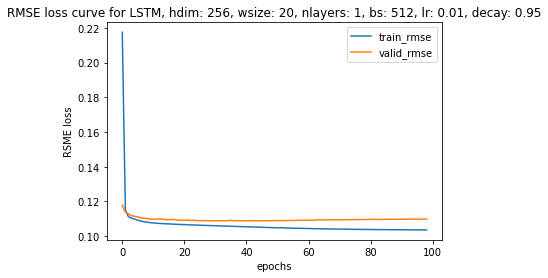

 44%|████▍     | 154/352 [02:02<01:36,  2.05it/s]


 88%|████████▊ | 308/352 [03:42<00:23,  1.90it/s]


100%|██████████| 352/352 [04:03<00:00,  1.45it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427, 0.10425, 0.10421, 0.10419, 0.10414, 0.10414, 0.10409, 0.10406, 0.10404, 0.10402, 0.10398, 0.10395, 0.10393, 0.10392, 0.10388, 0.10388, 0.10385, 0.10384, 0.10381, 0.1038, 0.10377, 0.10377, 0.10376, 0.10373, 0.10372, 0.10371, 0.1037, 0.10371, 0.10367, 0.10366, 0.10365, 0.10365, 0.10364, 0.10364, 0.10361, 0.1036, 0.10362]
0.10993
Epoch 100 | T: 4.72 | Train RMSE: 0.10362 | Valid RMSE: 0.10993


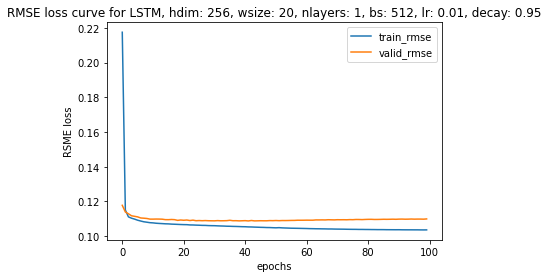

 44%|████▍     | 154/352 [02:05<01:40,  1.97it/s]


 88%|████████▊ | 308/352 [03:29<00:21,  2.07it/s]


100%|██████████| 352/352 [04:00<00:00,  1.46it/s]


[0.21745, 0.11508, 0.11112, 0.11035, 0.10982, 0.10919, 0.10872, 0.10829, 0.10804, 0.10777, 0.10765, 0.10745, 0.10733, 0.10723, 0.10712, 0.10707, 0.10694, 0.10687, 0.10679, 0.10671, 0.10665, 0.10662, 0.10647, 0.10644, 0.10636, 0.1063, 0.10622, 0.1062, 0.1061, 0.10605, 0.10603, 0.10594, 0.10587, 0.10582, 0.10573, 0.1057, 0.10563, 0.10559, 0.10553, 0.10546, 0.10543, 0.10533, 0.1053, 0.10522, 0.10516, 0.10509, 0.10505, 0.10497, 0.10495, 0.10487, 0.10481, 0.1049, 0.10478, 0.10471, 0.10465, 0.10458, 0.10455, 0.10452, 0.10448, 0.10444, 0.1044, 0.10434, 0.10431, 0.10427, 0.10425, 0.10421, 0.10419, 0.10414, 0.10414, 0.10409, 0.10406, 0.10404, 0.10402, 0.10398, 0.10395, 0.10393, 0.10392, 0.10388, 0.10388, 0.10385, 0.10384, 0.10381, 0.1038, 0.10377, 0.10377, 0.10376, 0.10373, 0.10372, 0.10371, 0.1037, 0.10371, 0.10367, 0.10366, 0.10365, 0.10365, 0.10364, 0.10364, 0.10361, 0.1036, 0.10362, 0.10359]


 10%|█         | 100/1000 [7:54:09<71:07:26, 284.50s/it]

0.10992


In [45]:
train_rmse = []
valid_rmse = []
min_rmse = 10e8

for i in tqdm(range(num_epoch)):
    start = time.time()

    model.train() # if you use dropout or batchnorm. 
    train_rmse.append(train_epoch(train_loader, model, optimizer, loss_fun))
    print(train_rmse)
    
    model.eval()
    val_rmse = eval_epoch(valid_loader, model, loss_fun)
    valid_rmse.append(val_rmse)
    print(val_rmse)

    # save the best model
    if valid_rmse[-1] < min_rmse:
        min_rmse = valid_rmse[-1] 
        best_model = model
        
        # torch.save([best_model, i, get_lr(optimizer)], name + ".pth")

    end = time.time()
    
    # Early Stopping
    if (len(train_rmse) > 100 and np.mean(valid_rmse[-5:]) >= np.mean(valid_rmse[-10:-5])):
        torch.save(best_model.state_dict(), f'lstm_hdim_{hidden_dim}_wsize_{window_size}_interval_{interval}_nlayers_{num_layers}_bs_{batch_size}_lr_{learning_rate}_decay_{decay_rate}_epoch_{i+1}.pt')    
        break       

    # Learning Rate Decay        
    scheduler.step()
    
    print("Epoch {} | T: {:0.2f} | Train RMSE: {:0.5f} | Valid RMSE: {:0.5f}".format(i + 1, (end-start) / 60, train_rmse[-1], valid_rmse[-1]))

    plt.figure()
    plt.plot(train_rmse, label="train_rmse")
    plt.plot(valid_rmse, label="valid_rmse")
    plt.xlabel('epochs')
    plt.ylabel('RSME loss')
    plt.title(f'RMSE loss curve for LSTM, hdim: {hidden_dim}, wsize: {window_size}, nlayers: {num_layers}, bs: {batch_size}, lr: {learning_rate}, decay: {decay_rate}')
    plt.legend()
    plt.savefig(f'lstm_loss_curve_v1_hdim_{hidden_dim}_wsize_{window_size}_interval_{interval}_nlayers_{num_layers}_bs_{batch_size}_lr_{learning_rate}_decay_{decay_rate}.png')
    plt.show()
    

# Evaluation and Submission

In [25]:
model.load_state_dict(torch.load('lstm_hdim_32_wsize_20_interval_7_nlayers_1_bs_512_lr_0.01_decay_0.95.pt'))
best_model = model

In [26]:
best_model

MyLSTM(
  (lstm): LSTM(4, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=4, bias=True)
)

In [46]:
test_path = "../val_in/val_in/"
test_pkl_list = glob(os.path.join(test_path, '*'))
test_pkl_list.sort()

test_preds = []
for idx in range(len(test_pkl_list)):
    with open(test_pkl_list[idx], 'rb') as f:
        test_sample = pickle.load(f)
        pred_id = np.where(test_sample["track_id"] == test_sample['agent_id'])[0][0]
        inp_scene = np.dstack([test_sample['p_in'], test_sample['v_in']])

        # Normalization 
        min_vecs = np.min(inp_scene, axis = (0,1))
        max_vecs = np.max(inp_scene, axis = (0,1))
        #print(min_vecs.shape)
        #print(max_vecs.shape)
        
        inp = (inp_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        
        inp = torch.from_numpy(inp).float().to(device).unsqueeze(0)

        #print(inp)
        # post-processing for LSTM
        predictions = [[]]
        inp_data = inp[0][-1]
        #print(inp_data.size())
        for i in range(30):
            preds = best_model(inp_data.reshape(1, 1, 4))
            predictions[0].append(preds[0].cpu().data.numpy()[0, :2])
            #print(preds)
            inp_data = preds[0]
            
#         print(inp[0][-1])
#         preds = best_model(inp)#.cpu().data.numpy()
#         print(preds)
#         print(inp.shape)
#         print(preds[0].shape)

        predictions = np.array(predictions)
        #print(predictions.shape)

        # De-Normalization ! 
        predictions = predictions * (max_vecs[:2] - min_vecs[:2]) +  min_vecs[:2]
        test_preds.append(predictions)

In [47]:
print(test_preds[0].shape)
print(test_preds[0])

(1, 30, 2)
[[[1707.06943497  342.62739893]
  [1702.60312744  347.09504732]
  [1699.73601729  350.25426716]
  [1697.97752445  352.49112351]
  [1696.99147412  354.07663414]
  [1696.54594626  355.20169378]
  [1696.47925234  356.0009824 ]
  [1696.67829363  356.56965288]
  [1697.06347442  356.97491431]
  [1697.57912973  357.26447401]
  [1698.18520161  357.47196926]
  [1698.85401363  357.62143913]
  [1699.56600502  357.72959319]
  [1700.30712948  357.80856005]
  [1701.06739853  357.8668472 ]
  [1701.83994509  357.91038804]
  [1702.61956681  357.94347996]
  [1703.40293422  357.96917691]
  [1704.18744615  357.9896603 ]
  [1704.97143784  358.00632623]
  [1705.75366073  358.02033085]
  [1706.53328246  358.03239402]
  [1707.3095747   358.04319198]
  [1708.08212125  358.05294286]
  [1708.85050594  358.06201751]
  [1709.61483281  358.07056861]
  [1710.37489376  358.0787707 ]
  [1711.13037666  358.08664557]
  [1711.88138556  358.09434593]
  [1712.6278164   358.10193722]]]


# Generate Submission File

### Steps to create submission file 
Run the below cells. The last cell will generate a submission file "test_submission.csv" that you can submit to Kaggle.

In [48]:
# Submission Files
sample_sub = pd.read_csv('sample_submission.csv')

In [51]:
# Save for later use
predictions = np.concatenate(test_preds).reshape(len(test_preds), -1).astype(int)
sub_df = pd.DataFrame(np.c_[sample_sub["ID"], predictions], columns=[np.r_[["ID"], ["v" + str(i) for i in range(1, 61)]]])
sub_df.to_csv(f'test_submission_lstm_hdim_{hidden_dim}_wsize_{window_size}_interval_{interval}_nlayers_{num_layers}_bs_{batch_size}_lr_{learning_rate}_decay_{decay_rate}.csv', index=None)

In [49]:
# Convert to float
predictions = np.concatenate(test_preds).reshape(len(test_preds), -1)
sub_df = pd.DataFrame(np.c_[sample_sub["ID"], predictions], columns=[np.r_[["ID"], ["v" + str(i) for i in range(1, 61)]]])
sub_df["ID"] = sub_df["ID"].astype(int)
sub_df.to_csv('test_submission.csv', index=None)

In [50]:
sub_df

ID           v1           v2           v3           v4           v5  \
0     10002  1707.069435   342.627399  1702.603127   347.095047  1699.736017   
1     10015   722.980768  1251.860879   721.325888  1267.420716   720.294335   
2     10019   573.051285  1257.727421   572.617448  1266.826828   572.419882   
3     10028  1695.261486   313.107377  1697.952629   311.723534  1699.819619   
4      1003  2123.997283   679.815715  2124.233766   680.977836  2124.690095   
...     ...          ...          ...          ...          ...          ...   
3195   9897   256.324537   803.807454   256.464422   802.358461   256.606635   
3196     99   587.845933  1156.063884   587.954769  1157.138338   588.126757   
3197   9905  1751.709348   448.663023  1749.317900   451.899631  1747.875421   
3198   9910   575.012730  1289.650775   575.434506  1289.909519   575.909897   
3199   9918   586.203515  1163.450581   587.692167  1161.487215   589.080079   

               v6           v7           v8           v9  ...          v51  \
0      350.254267  1697.977524   352.491124  1696.991474  ...  1709.614833   
1     1278.489141   719.696703  1286.369285   719.402320  ...   726.285962   
2     1273.216702   572.390843  1277.720828   572.480279  ...   578.955728   
3      310.762565  1701.185951   310.095857  1702.224959  ...  1711.198727   
4      681.807204  2125.296657   682.399722  2126.005080  ...  2143.604081   
...           ...          ...          ...          ...  ...          ...   
3195   801.218832   256.749301   800.330833   256.892000  ...   260.119891   
3196  1157.886899   588.340325  1158.414123   588.581747  ...   594.605896   
3197   454.150355  1747.057845   455.731974  1746.665980  ...  1756.621323   
3198  1290.009018   576.411683  1290.027674   576.926256  ...   587.360471   
3199  1159.951344   590.378926  1158.784861   591.604769  ...   611.388024   

              v52          v53          v54          v55          v56  \
0      358.070569  1710.374894   358.078771  1711.130377   358.086646   
1     1305.901702   726.676191  1305.909102   727.064450  1305.916344   
2     1289.197833   579.265204  1289.230209   579.572433  1289.261957   
3      308.769297  1711.566360   308.776940  1711.934196   308.784453   
4      683.878419  2144.393508   683.876131  2145.177432   683.873595   
...           ...          ...          ...          ...          ...   
3195   797.187534   260.275608   797.187825   260.430532   797.189769   
3196  1160.201296   594.883850  1160.227241   595.160135  1160.252973   
3197   459.842434  1757.189464   459.854555  1757.755713   459.866285   
3198  1290.052863   587.823075  1290.079391   588.282389  1290.106234   
3199  1155.766704   612.196281  1155.788097   612.995975  1155.809913   

              v57          v58          v59          v60  
0     1711.881386   358.094346  1712.627816   358.101937  
1      727.450695  1305.923824   727.834656  1305.931702  
2      579.877556  1289.293154   580.180504  1289.323723  
3     1712.302031   308.791796  1712.670068   308.798971  
4     2145.955469   683.871099  2146.728004   683.868645  
...           ...          ...          ...          ...  
3195   260.584599   797.193317   260.737810   797.198176  
3196   595.434821  1160.278705   595.707801  1160.303871  
3197  1758.319859   459.877622  1758.881588   459.888652  
3198   588.738487  1290.133234   589.191295  1290.160392  
3199   613.787189  1155.832435   614.570168  1155.855239  

[3200 rows x 61 columns]

In [ ]:
# Ensemble Method 